In [1]:
from IPython.display import display, HTML

display(
    HTML(
        """
<img src="../resources/images/header_small.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)


<meta name="viewport" content="width=device-width, initial-scale=1">
<meta name="description" content="Building and validating machine learning models to predict employee churn at Salifort Motors. Emphasis on recall and interpretability.">
<title>Classified: At-Risk – Salifort Churn Prediction</title>
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.2/css/all.min.css">
<link rel="stylesheet" href="../static/css/styles.css">
<link rel="icon" href="../static/images/favicon.ico" type="image/ico" />


<!-- <body> -->
<!-- Navigation-->
<nav class="navbar navbar-expand-lg navbar-light fixed-top" id="mainNav">
    <div class="container px-4 px-lg-5">
        <a class="navbar-brand" href="../index.html">Home</a>
        <button class="navbar-toggler" type="button" data-bs-toggle="collapse" data-bs-target="#navbarResponsive" aria-controls="navbarResponsive" aria-expanded="false" aria-label="Toggle navigation">
            Menu
            <i class="fas fa-bars"></i>
        </button>
        <div class="collapse navbar-collapse" id="navbarResponsive">
            <ul class="navbar-nav ms-auto py-4 py-lg-0">
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="../index.html">Executive Summary</a></li>
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="eda.html">Exploratory Data Analysis</a></li>
                <!-- <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="models.html">Model Construction & Validation</a></li> -->
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="initial_work.html">Reference: Model Development</a></li>
            </ul>
        </div>
    </div>
</nav>

<h2 id="title" style="text-align: center; width: 80%;">Model Construction and Validation</h2>

# Table of Contents

- [Description and Deliverables](#description-and-deliverables)
- [Exploratory Data Analysis Insights](#insights)
- [Modeling Strategies Recap](#modeling-strategies-recap)
  - [Cross-Validation Results](#cross-validation-results)
- [Model Selection](#model-selection)
  - [Logistic Regression Selection](#logistic-regression-selection)
  - [Decision Tree Selection](#decision-tree-selection)
  - [Random Forest Selection](#random-forest-selection)
  - [XGBoost Selection](#xgboost-selection)
- [Model Results & Interpretation](#model-results)
  - [Logistic Regression Interpretation](#logistic-regression-interpretation)
  - [Decision Tree Interpretation](#decision-tree-interpretation)
  - [Random Forest Interpretation](#random-forest-interpretation)
  - [XGBoost Interpretation](#xgboost-interpretation)
  - [Cross-Model Reflection](#cross-model-reflection)
- [Conclusion](#conclusion)
- [Appendix: Data Dictionary](#appendix-data-dictionary)
- [Appendix: Feature Engineering](#appendix-feature-engineering)
- [Appendix: Hyperparameter Tuning Grids](#appendix-hyperparameters)

<div class="circle-separator-anchor"></div>

<a id="description-and-deliverables"></a>

# **Description and Deliverables**
---

[Back to top](#)

This project builds on insights from exploratory data analysis (EDA) to **develop predictive models for employee attrition** at Salifort Motors. The primary objective was to identify employees at risk of leaving, enabling targeted retention strategies. The modeling process was designed to be rigorous, transparent, and accessible to both technical and non-technical stakeholders.

**Stakeholders:**  
The primary stakeholder is the Human Resources (HR) department, as they will use the results to inform retention strategies. Secondary stakeholders include C-suite executives who oversee company direction, managers implementing day-to-day retention efforts, employees (whose experiences and outcomes are directly affected), and, indirectly, customers—since employee satisfaction can impact customer satisfaction.

**Ethical Considerations:**  
- Ensure employee data privacy and confidentiality throughout the analysis.
- Avoid introducing or perpetuating bias in model predictions (e.g., not unfairly targeting specific groups).
- Maintain transparency in how predictions are generated and how they will be used in HR decision-making.

### This page summarizes the second part of the project: predictive model construction and validation, with interpretation of results.

In [2]:
# Import packages
import time
import joblib
import os
import re

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.tree import plot_tree, export_text
import shap

# from IPython.display import display, HTML

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    precision_recall_curve,
    average_precision_score,
)

In [3]:
# Load dataset into a dataframe
df0 = pd.read_csv("../resources/HR_capstone_dataset.csv")

In [4]:
# Rename columns as needed
df0.rename(
    columns={
        "Department": "department",
        "Work_accident": "work_accident",
        "average_montly_hours": "average_monthly_hours",
        "time_spend_company": "tenure",
    },
    inplace=True,
)

In [5]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df = df0.drop_duplicates()

In [6]:
# Determine the number of rows containing tenure outliers
q1 = df.tenure.quantile(0.25)
q3 = df.tenure.quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# # Filter the dataframe to find outliers
# outliers = df[df.tenure > upper_bound]

# # Display the number of outliers
# print(f"Number of tenure outliers: {len(outliers)}")
# print(f"Outliers percentage of total: {len(outliers) / len(df) * 100:.2f}%")

<div class="circle-separator-anchor"></div>

<a id="insights"></a>

# **Exploratory Data Analysis Insights**
---

[Back to Top](#)

#### A quick recap of the [exploratory data analysis](./eda.html):

The data suggests significant challenges with employee retention at this company. Two main groups of leavers emerge:

- **Underutilized and Dissatisfied:** Employees in this category worked on fewer projects and logged fewer hours than a typical full-time schedule, and reported lower satisfaction. These individuals may have been disengaged, assigned less work as they prepared to leave, or potentially subject to layoffs or terminations.
- **Overworked and Burned Out:** The second group managed a high number of projects (up to 7) and worked exceptionally long hours—sometimes nearing 80 hours per week. These employees exhibited very low satisfaction and rarely received promotions, suggesting that high demands without recognition or advancement led to burnout and resignation.

A majority of the workforce greatly exceeds the typical 40-hour work week (160–184 hours per month), pointing to a workplace culture that expects long hours. The combination of high workload and limited opportunities for advancement likely fuels dissatisfaction and increases the risk of turnover.

Performance evaluations show only a weak link to attrition; both those who left and those who stayed received similar review scores. This indicates that strong performance alone does not guarantee retention, especially if employees are overworked or lack opportunities for growth.

Other variables—such as department, salary, and work accidents—do not show strong predictive value for employee churn compared to satisfaction and workload. Overall, **the data points to issues with workload management** and limited career progression as the main factors driving employee turnover at this company.

<div class="circle-separator-anchor"></div>

<a id="modeling-strategies-recap"></a>

# **Modeling Strategies Recap**
---

[Back to top](#)

*This section summarizes the modeling strategy, key lessons learned, and the criteria used to select the final models.*

#### Approach

Given the business context, the modeling strategy **prioritized recall**—the ability to identify as many at-risk employees as possible—while also considering precision and model simplicity. Four model types were evaluated: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Each model was developed using a systematic pipeline approach to ensure reproducibility and prevent data leakage.

Key steps included:
- **Data Preparation**: Outliers were removed for logistic regression, and all preprocessing was handled within scikit-learn `Pipelines`.
- **Cross-Validation**: Stratified K-Fold cross-validation was used throughout to ensure robust performance estimates, especially given class imbalance.
- **Hyperparameter Tuning**: `GridSearchCV` was used for simpler models, while `RandomizedSearchCV` was adopted for more complex models to balance thoroughness and computational efficiency. Details [here](#appendix-hyperparameters).
- **Feature Engineering**: Multiple rounds of feature engineering and selection were conducted, focusing on satisfaction, workload, tenure, and interaction terms identified as important in EDA. Details [here](#appendix-feature-engineering).
- **Model Evaluation**: In addition to standard metrics (recall, precision, F₁, ROC AUC), a custom F₂ score was introduced to explicitly weight recall four times higher than precision, reflecting the business priority of minimizing false negatives.

#### Lessons Learned

The modeling process was iterative and exploratory, reflecting both best practices and lessons learned:
- **Metric Selection Matters**: Initial experiments optimizing for AUC led to suboptimal recall, especially for logistic regression. Refocusing on recall as the primary metric improved model alignment with business goals.
- **Model Complexity vs. Interpretability**: Tree-based models (Random Forest, XGBoost) consistently outperformed logistic regression in overall metrics, but targeted feature engineering allowed logistic regression to become competitive while remaining highly interpretable.
- **Feature Engineering**: Additional features and interaction terms provided modest improvements, but the most significant gains came from careful feature selection and focusing on core predictors.
- **Efficiency and Automation**: Automating pipeline construction and model evaluation streamlined experimentation and reduced the risk of errors or data leakage.


#### Final Model Selection

With several high-performing models, explicit selection criteria were established:

1. Minimum recall threshold (≥ 0.935)
2. Minimum F₂ score (≥ 0.85)
3. Fewest features (for simplicity and interpretability)
4. Highest F₂ score
5. Highest precision

This approach ensured that the final models were not only accurate but also practical for deployment and stakeholder communication.

#### Next Steps

The selected models will be retrained on the full training set and evaluated on the holdout test set (`X_test`). Results—including confusion matrices, feature importances, and actionable insights—will be communicated to HR and leadership to inform retention strategies. The process and findings will be documented to support transparency, ethical use, and ongoing model improvement.

<div class="circle-separator-anchor"></div>

<a id="cross-validation-results)"></a>

## Cross-Validation Results
---

[Back to top](#)

This section presents the cross-validated results of all modeling strategies to date. Here, we summarize model performance prior to retraining the final selected models on the full training set and evaluating them on the holdout test set (`X_test`). The results include a comprehensive table of evaluation metrics for each model, as well as visualizations of confusion matrices for both the baseline and top-performing models. These outputs provide a clear comparison of model effectiveness and support transparent, data-driven model selection.

In [7]:
# show confusion matrix exemplar
# display(Image(filename="../resources/images/confusion_matrix_exemplar.png", width=800))
display(
    HTML(
        """
<img src="../resources/images/confusion_matrix_exemplar.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)

In [8]:
# display confusion matrix for all models, top 9
# display(Image(filename="../results/images/top_model_confusion_matrices_confusion_grid.png", width=800))
display(
    HTML(
        """
<img src="../results/images/top_model_confusion_matrices_confusion_grid.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)

In [9]:
# # display confusion matrix for base model
# # display(Image(filename="../results/images/base_model_confusion_matrices_confusion_grid.png", width=800))
# display(
#     HTML(
#         """
# <img src="../results/images/base_model_confusion_matrices_confusion_grid.png" style="max-width:100%; height:auto; display:block; margin:auto;">
# """
#     )
# )

In [10]:
# display all model evaluation results
df_results = pd.read_csv("../results/all_model_evaluation_results.csv")
df_results = df_results.rename(
    columns={
        "model": "Model",
        "recall": "Recall",
        "f2": "F2 Score",
        "f1": "F1 Score",
        "pr_auc": "PR AUC",
        "roc_auc": "ROC AUC",
        "precision": "Precision",
        "accuracy": "Accuracy",
        "features": "Num Features",
        "best_params": "Best Params",
        "cv_best_score": "CV Best Score",
        "conf_matrix": "Confusion Matrix",
        "search_time": "Search Time (s)",
    }
)
# # display as a scrollable HTML table
# display(HTML(
#     df_results[
#         [
#             "Model",
#             "Recall",
#             "F2 Score",
#             "F1 Score",
#             "Precision",
#             "Accuracy",
#             "ROC AUC",
#             "Num Features",
#             "Confusion Matrix",
#             "Search Time (s)",
#         ]
#     ].to_html(
#         index=False,
#         escape=False,
#         classes="table table-striped table-hover scroll-table",
#         border=0
#     )
# ))
df_results[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
        "Search Time (s)",
    ]
]

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix,Search Time (s)
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.444262,0.888335,6,"[[6039, 1389], [57, 1448]]",0.748892
1,Logistic Regression with Interaction (Feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.452351,0.891666,10,"[[6073, 1355], [60, 1445]]",2.670381
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.502425,0.903177,6,"[[6210, 1218], [73, 1432]]",0.886503
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.464504,0.891388,18,"[[5919, 1509], [79, 1426]]",5.255588
4,Logistic Regression (Minimal Base),0.944186,0.801195,0.652883,0.498947,0.830852,0.440759,0.882956,6,"[[6001, 1427], [84, 1421]]",0.419974
5,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.808572,0.956257,7,"[[7402, 597], [90, 1503]]",3.426816
6,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.751529,0.945551,18,"[[7355, 644], [92, 1501]]",3.081794
7,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.931132,0.976981,7,"[[7508, 491], [94, 1499]]",71.972421
8,Logistic Regression (Minimal Interaction),0.940864,0.794613,0.644369,0.489965,0.825031,0.428805,0.877167,6,"[[5954, 1474], [89, 1416]]",0.664550
9,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.846457,0.964169,18,"[[7198, 801], [95, 1498]]",198.148717


<div class="circle-separator-anchor"></div>

<a id="model-selection"></a>

# **Model Selection**
---

[Back to top](#)

*This section details the selection process, data dictionary, and best hyperparameters for each final model.*

### Model Evaluation Strategy

All models were tuned using cross-validation and evaluated primarily on **recall**, followed by **F₂-score**, and **interpretability**.

While **ROC AUC** provides a threshold-independent measure of class separability, it is not well suited for highly **imbalanced datasets** such as employee churn, where the positive class is both underrepresented and strategically critical. In such cases, the AUC may overstate model effectiveness by overvaluing correct classification of the dominant class.

**Recall** was selected as the primary metric to maximize identification of at-risk employees (true positives), consistent with a retention-oriented business strategy. False negatives—failing to flag someone likely to leave—are costlier than false positives, especially when interventions are designed to be **supportive, not punitive**.

While **precision** remains a secondary concern (to avoid unnecessary HR interventions), the assumption is that the cost of a missed opportunity to support an employee outweighs the cost of a misplaced flag.

To ensure ethical application of the model:
- Deploy with clear usage guidelines.
- Ensure transparency in decision-making.
- Calibrate model outputs.
- Conduct periodic fairness and impact audits.

---

### Tie-Breaker Criteria for Model Selection

In practice, multiple models achieved similar performance levels on recall (ranging from 0.93–0.96). To break ties post-evaluation, models are ranked using the following ordered criteria:

1. **Recall > 0.935**
2. **F₂-score > 0.85**
3. **Fewest number of features**
4. **Highest F₂-score**
5. **Highest precision**

This sequential filtering ensures that selected models are both performant and practically deployable, favoring recall-focused designs with lower feature complexity for ease of explanation and maintenance.

In [11]:
"""Set evaluation metric"""

scoring = "recall"


# for XGBoost eval_metric
def get_xgb_eval_metric(scoring):
    mapping = {
        "roc_auc": "auc",  # area under ROC curve
        "accuracy": "error",  # classification error rate
        "f1": "logloss",  # logarithmic loss (not F1, but closest available)
        "precision": "logloss",  # no direct precision metric, logloss is a common fallback
        "recall": "logloss",  # no direct recall metric, logloss is a common fallback
    }
    return mapping.get(scoring, "auc")  # default to 'auc' if not found

In [12]:
"""Encode categorical variables."""

# copy the dataframe to avoid modifying the original
df_enc = df.copy()

# encode salary as ordinal
df_enc["salary"] = df_enc["salary"].map({"low": 0, "medium": 1, "high": 2})

# encode department as dummies
df_enc = pd.get_dummies(df_enc, columns=["department"])

In [13]:
"""
Split the data into train / test sets for different models

One set for tree-based models (decision tree, random forest, XGBoost)
Another set for logistic regression (which must have outliers removed and data normalized)
Stratify the target variable each time to account for class imbalance.
"""


# split the data into features and target variable for tree-based models
X = df_enc.drop(columns=["left"])
y = df_enc["left"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# scale_pos_weight for XGBoost (ratio of negative to positive class in training set)
# handles class imbalance
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

In [14]:
# split the data into features and target variable for logistic regression
# remove outliers from tenure for logistic regression
df_enc_lr = df_enc.copy()

"""
outliers defined waaaaaay up above, 
at end of inital data exploration and cleaning
code not needed here, but copied for reference
"""
# q1 = df.tenure.quantile(0.25)
# q3 = df.tenure.quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr

# remove outliers
df_enc_lr = df_enc_lr[df_enc_lr.tenure < upper_bound]

X_lr = df_enc_lr.drop(columns=["left"])
y_lr = df_enc_lr["left"]

# split the data into training and testing sets for logistic regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42, stratify=y_lr
)

In [15]:
"""
Supporting functions for model evaluation and feature engineering.

Functions to assemble model configurations,
run those models through cross-validation and hyperparameter tuning for evaluation,
and do feature engineering.
"""


# build models_config for run_model_evaluation
def make_models_config(
    models,
    X_train,
    y_train,
    feature_func=None,  # can be a function, list, dict, or None
    param_grids=None,
    scaler=None,
    name_suffix="",
):
    """
    Build models_config for run_model_evaluation.
    - models: dict of {name: estimator}
    - X_train, y_train: training data
    - feature_func: function, list of functions, dict of {name: func}, or None
    - param_grids: dict of {name: param_grid} (or None for empty)
    - scaler: sklearn transformer (e.g., StandardScaler) or None
    - name_suffix: string to append to model name
    """
    configs = []
    for name, model in models.items():
        # order of steps matters, features first, then scaler, then model
        steps = []

        # determine which feature_func to use for this model
        func = None
        if isinstance(feature_func, dict):  # dict of {name: func}
            func = feature_func.get(name)
        elif callable(feature_func) or isinstance(feature_func, list):
            func = feature_func
        # handles a list of feature functions (apply in sequence), or a single function
        if func is not None:
            if isinstance(func, list):
                for i, f in enumerate(func):
                    steps.append((f"features_{i+1}", FunctionTransformer(f)))
            else:
                steps.append(("features", FunctionTransformer(func)))

        # add scaler if provided
        if scaler is not None:
            steps.append(("scaler", scaler))

        # add model
        steps.append(("model", model))

        # create the pipeline
        pipe = Pipeline(steps)

        # add parameter grid if provided
        param_grid = {}
        if isinstance(param_grids, dict):
            param_grid = param_grids.get(name, {})

        # add model configuration to the list
        configs.append(
            {
                "name": f"{name}{name_suffix}",
                "X_train": X_train,
                "y_train": y_train,
                "pipeline": pipe,
                "param_grid": param_grid,
            }
        )
    return configs

In [16]:
# run model evaluation function
def run_model_evaluation(
    models_config,
    results_df=None,
    scoring="recall",
    save_model=False,
    search_type="grid",
    n_iter=20,
):
    """
    Run model training and evaluation for a list of model configurations using cross-validated hyperparameter search.

    For each model configuration, performs hyperparameter tuning (GridSearchCV or RandomizedSearchCV),
    fits the best pipeline, evaluates cross-validated performance metrics, and optionally saves the best model.

    Parameters:
        models_config (list of dict): List of model configurations, each containing:
            - 'name': Model name (str)
            - 'X_train': Training features (pd.DataFrame or np.ndarray)
            - 'y_train': Training labels (pd.Series or np.ndarray)
            - 'pipeline': sklearn Pipeline object
            - 'param_grid': dict of hyperparameters for search
        results_df (pd.DataFrame or None): Existing results DataFrame to append to, or None to create a new one.
        scoring (str): Scoring metric for model selection (e.g., 'recall', 'accuracy', 'roc_auc').
        save_model (bool): If True, saves the best model pipeline to disk for each configuration.
        search_type (str): 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
        n_iter (int): Number of parameter settings sampled for RandomizedSearchCV (ignored for grid search).

    Returns:
        pd.DataFrame: Results DataFrame with model name, metrics (recall, f1, roc_auc, precision, accuracy),
                      number of features, best hyperparameters, best CV score, confusion matrix, and search time.

    Notes:
        - Uses stratified 5-fold cross-validation for both hyperparameter search and out-of-fold predictions.
        - Calculates metrics on cross-validated predictions for robust performance estimates.
        - Handles models that do not support predict_proba for ROC AUC gracefully.
        - Saves models to '../results/saved_models/' if save_model=True.
    """
    if results_df is None:
        results_df = pd.DataFrame(
            columns=[
                "Model",
                "Recall",
                "F2",  # 80% recall, 20% precision (metric created to weigh recall more heavily)
                "F1",  # 50% recall, 50% precision
                "PR AUC",
                "ROC AUC",
                "Precision",
                "Accuracy",
                "Features",
                "Best Params",
                "CV Best Score",
                "Confusion Matrix",
                "Search Time (s)",
            ]
        )

    # ensure cross-validation is stratified for balanced class distribution
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for cfg in models_config:
        # time the model training and evaluation
        start_time = time.time()
        # print(f"Running model: {cfg['name']}...")

        # conditional to choose search type, instantiate the appropriate search class
        if search_type == "random":
            grid = RandomizedSearchCV(
                cfg["pipeline"],
                cfg["param_grid"],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                n_jobs=-1,
                # verbose=2,
                random_state=42,
            )
        else:
            grid = GridSearchCV(
                cfg["pipeline"],
                cfg["param_grid"],
                cv=cv,
                scoring=scoring,
                n_jobs=-1,
                # verbose=2,
            )

        # fit the grid search to the training data
        grid.fit(cfg["X_train"], cfg["y_train"])

        # print the execution time
        end_time = time.time()
        search_time = end_time - start_time
        # print(f"Execution time for {cfg['name']}: {search_time:.2f} seconds")

        # get the best model and its parameters
        best_model = grid.best_estimator_
        # print(f"Best parameters for {cfg['name']}: {grid.best_params_}")
        # print(f"Best score for {cfg['name']}: {grid.best_score_:.4f} ({scoring})")

        # --- get the number of features after all pipeline steps ---
        # try to transform X_train through all steps except the final estimator
        try:
            if hasattr(best_model, "named_steps"):
                # Remove the final estimator step
                steps = list(best_model.named_steps.items())
                if len(steps) > 1:
                    # Remove last step (the model)
                    feature_pipeline = Pipeline(steps[:-1])
                    X_transformed = feature_pipeline.transform(cfg["X_train"])
                    n_features = X_transformed.shape[1]
                else:
                    n_features = cfg["X_train"].shape[1]
            else:
                n_features = cfg["X_train"].shape[1]
        except Exception as e:
            print(f"Could not determine number of features: {e}")
            n_features = cfg["X_train"].shape[1]

        # conditional to save the best model
        if save_model:
            model_path = f"../results/saved_models/{cfg['name'].replace(' ', '_').lower()}.joblib"
            joblib.dump(best_model, model_path)
            # print(f"Model {cfg['name']} saved successfully.\n")
        else:
            print(f"Model {cfg['name']} not saved. Set save_model=True to save it.\n")

        # make predictions using cross-validation to generate out-of-fold predictions for each training sample
        # translation:
        # substitute for setting aside a validation set
        # takes more time, but provides better estimates of model performance
        # it makes a prediction for each sample in the training set, using a different fold of the data for each prediction...
        # ...the fold where the sample is not included in the 80% training set (the sample is in the 20%)
        y_pred = cross_val_predict(
            best_model, cfg["X_train"], cfg["y_train"], cv=cv, n_jobs=-1
        )

        # calculate the ROC AUC score, need predicted probabilities (not just class labels, but confidence in those labels)
        # try / except block to handle models that do not support predict_proba (e.g., SVC)
        try:
            y_proba = cross_val_predict(
                best_model,
                cfg["X_train"],
                cfg["y_train"],
                cv=cv,
                method="predict_proba",
                n_jobs=-1,
            )
            roc_auc = roc_auc_score(cfg["y_train"], y_proba[:, 1])
            pr_auc = average_precision_score(cfg["y_train"], y_proba[:, 1])
        except (AttributeError, ValueError):
            roc_auc = np.nan
            pr_auc = np.nan
            print(f"Model {cfg['name']} does not support predict_proba.")

        # save results in the results dataframe
        results_df.loc[len(results_df)] = {
            "Model": cfg["name"],
            "Features": n_features,
            "Accuracy": accuracy_score(cfg["y_train"], y_pred),
            "Precision": precision_score(cfg["y_train"], y_pred),
            "Recall": recall_score(cfg["y_train"], y_pred),
            "F1": f1_score(cfg["y_train"], y_pred),
            "F2": fbeta_score(
                cfg["y_train"], y_pred, beta=2
            ),  # 80% recall, 20% precision (ratio is "beta squared : 1", b^2:1, 2^2:1, 4:1)
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc,
            "Confusion Matrix": confusion_matrix(cfg["y_train"], y_pred).tolist(),
            "Best Params": grid.best_params_,
            "CV Best Score": grid.best_score_,
            "Search Time (s)": search_time,
        }

    return results_df

In [17]:
"""
feature engineering / feature selection functions
the functions commented out below are not used in the final notebook,
but were used during model development
and are included for reference
"""


# NOTE used in Logistic Regression's winner - "with Binning (feature selection)"
# add binning features
def add_binning_features(df):
    df = df.copy()
    df["satisfaction_bin"] = pd.cut(
        df["satisfaction_level"],
        bins=[-0.01, 0.4, 0.7, 1.0],
        labels=["low", "medium", "high"],
    )
    df["hours_bin"] = pd.cut(
        df["average_monthly_hours"],
        bins=[0, 160, 240, np.inf],
        labels=["low", "medium", "high"],
    )
    df["projects_bin"] = pd.cut(
        df["number_project"], bins=[0, 2, 5, np.inf], labels=["low", "medium", "high"]
    )
    df["tenure_bin"] = pd.cut(
        df["tenure"], bins=[0, 3, 5, np.inf], labels=["short", "mid", "long"]
    )
    # encode the binned features as dummies
    df = pd.get_dummies(
        df,
        columns=["satisfaction_bin", "hours_bin", "projects_bin", "tenure_bin"],
        drop_first=True,
    )
    return df


# NOTE used in Logistic Regression's winner - "with Binning (feature selection)"
# feature selection for logistic regression
drop_cols = [col for col in X_train_lr.columns if col.startswith("department_")]
drop_cols += ["salary", "work_accident"]
X_train_lr_fs = X_train_lr.drop(columns=drop_cols)

In [18]:
# NOTE This is the group of features that 'won' for all tree-based models
# selected features + burnout flag
def select_core_features_with_burnout(df):
    df = df.copy()
    # burnout flag: (projects >= 6 or hours >= 240) & satisfaction <= 0.3
    df["burnout"] = (
        (df["number_project"] >= 6) | (df["average_monthly_hours"] >= 240)
    ) & (df["satisfaction_level"] <= 0.3)
    return df[
        [
            "satisfaction_level",
            "last_evaluation",
            "number_project",
            "average_monthly_hours",
            "tenure",
            "promotion_last_5years",
            "burnout",
        ]
    ]

<div class="circle-separator-anchor"></div>

<a id="logistic-regression-selection"></a>

## Logistic Regression Selection
---

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

Due to severe multicollinearity (VIFs > 10, sometimes > 30), most of these models are not suitable for interpretation or inference. I therefore focus on models with lower VIFs (e.g., the base and minimal binned models).

In [19]:
# logistic regression feature engineering hyperparameters
lr_fe_params = {
    "model__C": [0.1, 1.0, 10.0],  # regularization strength (inverse)
    "model__penalty": ["l1", "l2"],  # regularization type (L1 = Lasso, L2 = Ridge)
    "model__solver": ["liblinear"],  # optimization algorithm (liblinear supports L1/L2)
    "model__class_weight": [None, "balanced"],  # None or balanced for class imbalance
}

# define feature engineered logistic regression models, their feature functions, and parameter grids
lr_fe_models = {
    "Logistic Regression with Binning": LogisticRegression(
        max_iter=1000, random_state=42
    ),
}
lr_fe_feature_funcs = {
    "Logistic Regression with Binning": add_binning_features,
}
lr_fe_param_grids = {
    "Logistic Regression with Binning": lr_fe_params,
}

# create models_config for logistic regression with feature engineering and feature selection
lr_fe_fs_configs = make_models_config(
    lr_fe_models,
    X_train_lr_fs,
    y_train_lr,
    feature_func=lr_fe_feature_funcs,
    scaler=StandardScaler(),
    param_grids=lr_fe_param_grids,
    name_suffix=" (feature selection)",
)

All Logistic Regression Models:

In [20]:
# display model evaluation results for all logistic regression models
df_lr = df_results[df_results["Model"].str.contains("Logistic Regression")]
if df_lr.empty:
    print("No logistic regression models found in results.")

# print("Logistic Regression Model Evaluation Results:")
df_lr = df_lr[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_lr

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.444262,0.888335,6,"[[6039, 1389], [57, 1448]]"
1,Logistic Regression with Interaction (Feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.452351,0.891666,10,"[[6073, 1355], [60, 1445]]"
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.502425,0.903177,6,"[[6210, 1218], [73, 1432]]"
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.464504,0.891388,18,"[[5919, 1509], [79, 1426]]"
4,Logistic Regression (Minimal Base),0.944186,0.801195,0.652883,0.498947,0.830852,0.440759,0.882956,6,"[[6001, 1427], [84, 1421]]"
8,Logistic Regression (Minimal Interaction),0.940864,0.794613,0.644369,0.489965,0.825031,0.428805,0.877167,6,"[[5954, 1474], [89, 1416]]"
10,Logistic Regression with Binning (Feature Sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.708096,0.947481,14,"[[6594, 834], [91, 1414]]"
11,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.740611,0.952159,26,"[[6607, 821], [94, 1411]]"
18,Logistic Regression (Core + Burnout),0.934884,0.798796,0.655638,0.504844,0.834546,0.459660,0.886564,7,"[[6048, 1380], [98, 1407]]"
22,Logistic Regression with Interaction,0.933555,0.808121,0.672571,0.525627,0.846860,0.478629,0.901327,22,"[[6160, 1268], [100, 1405]]"


Above the minimum recall threshold of 0.935:

In [21]:
df_lr_1 = df_lr[df_lr["Recall"] >= 0.935]
df_lr_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.444262,0.888335,6,"[[6039, 1389], [57, 1448]]"
1,Logistic Regression with Interaction (Feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.452351,0.891666,10,"[[6073, 1355], [60, 1445]]"
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.502425,0.903177,6,"[[6210, 1218], [73, 1432]]"
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.464504,0.891388,18,"[[5919, 1509], [79, 1426]]"
4,Logistic Regression (Minimal Base),0.944186,0.801195,0.652883,0.498947,0.830852,0.440759,0.882956,6,"[[6001, 1427], [84, 1421]]"
8,Logistic Regression (Minimal Interaction),0.940864,0.794613,0.644369,0.489965,0.825031,0.428805,0.877167,6,"[[5954, 1474], [89, 1416]]"
10,Logistic Regression with Binning (Feature Sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.708096,0.947481,14,"[[6594, 834], [91, 1414]]"
11,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.740611,0.952159,26,"[[6607, 821], [94, 1411]]"


Above the minimum F₂ threshold of 0.85:

In [22]:
df_lr_2 = df_lr_1[df_lr_1["F2 Score"] >= 0.85]
df_lr_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
10,Logistic Regression with Binning (Feature Sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.708096,0.947481,14,"[[6594, 834], [91, 1414]]"
11,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.740611,0.952159,26,"[[6607, 821], [94, 1411]]"


With the fewest features:

In [23]:
df_lr_winner = df_lr_2[df_lr_2["Num Features"] == df_lr_2["Num Features"].min()]
df_lr_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
10,Logistic Regression with Binning (Feature Sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.708096,0.947481,14,"[[6594, 834], [91, 1414]]"


The selected model is "**Logistic Regression with Binning (feature selection)**"

In [24]:
""" 
Model, feature function, and parameter grid definitions
 (used to build pipelines) 
 located at beginning of Logistic Regression section 
 """
results_training = run_model_evaluation(
    lr_fe_fs_configs, scoring=scoring, save_model=True
)
# results_training

#### Data Dictionary: 

**Logistic Regression with Binning and Feature Selection**

This model uses a subset of the original features, applies binning to key variables, and drops department, salary, and work_accident.

| Variable                       | Description                                                                                 |
|---------------------------------|---------------------------------------------------------------------------------------------|
| satisfaction_level              | Employee-reported job satisfaction level [0–1]                                              |
| last_evaluation                 | Score of employee's last performance review [0–1]                                           |
| number_project                  | Number of projects employee contributes to                                                  |
| average_monthly_hours           | Average number of hours employee worked per month                                           |
| tenure                          | How long the employee has been with the company (years)                                     |
| promotion_last_5years           | Whether or not the employee was promoted in the last 5 years                                |
| satisfaction_bin_medium         | Binary indicator: satisfaction_level is medium (> 0.4 and ≤ 0.7)                            |
| satisfaction_bin_high           | Binary indicator: satisfaction_level is high (> 0.7)                                       |
| hours_bin_medium                | Binary indicator: average_monthly_hours is medium (> 160 and ≤ 240)                         |
| hours_bin_high                  | Binary indicator: average_monthly_hours is high (> 240)                                    |
| projects_bin_medium             | Binary indicator: number_project is medium (> 2 and ≤ 5)                                    |
| projects_bin_high               | Binary indicator: number_project is high (> 5)                                             |
| tenure_bin_mid                  | Binary indicator: tenure is mid (> 3 and ≤ 5 years)                                        |
| tenure_bin_long                 | Binary indicator: tenure is long (> 5 years)                                               |

- All binned features are one-hot encoded, with the first category dropped (i.e., "low" or "short" is the reference).

---

Hyperparameters for **Logistic Regression with Binning and Feature Selection**:

```python
{
    'model__C': 0.1,                     # Strong L1 regularization (encourages sparsity/feature selection)
    'model__class_weight': 'balanced',   # Adjusts for class imbalance
    'model__penalty': 'l1',              # L1 penalty (Lasso)
    'model__solver': 'liblinear'         # Solver supporting L1/L2 penalties
}
```


In [25]:
# # tree-based feature engineering parameters
tree_fe_params = {
    "Random Forest": {
        "model__n_estimators": [100, 300],  # 300 was best, but 100 is faster for FE
        "model__max_depth": [
            3,
            4,
            5,
            8,
        ],  # 5 was best, trying for regularization, deeper trees can overfit, take longer to train
        "model__max_features": ["sqrt", 1.0],  # 1.0 was best, but sqrt is common
        "model__max_samples": [0.7, 1.0],  # 1.0 was best
        "model__min_samples_leaf": [1, 2],  # 1 or 2
        "model__min_samples_split": [2, 3],  # 2 or 3
        "model__class_weight": [
            None,
            "balanced",
        ],  # None or balanced for class imbalance
    },
    "XGBoost": {
        "model__n_estimators": [100, 300],  # 300 was best
        "model__max_depth": [
            3,
            4,
            5,
            8,
        ],  # 3 was best (moderate increase in training time)
        "model__learning_rate": [
            0.1,
            0.2,
        ],  # 0.1 is standard, 0.2 for speed, step size shrinkage
        "model__subsample": [
            0.6,
            0.8,
            1.0,
        ],  # 1.0 was best, row subsampling (adds randomness, helps generalization)
        "model__colsample_bytree": [
            0.6,
            0.8,
            1.0,
        ],  # 1.0 was best, column subsampling (adds randomness, helps generalization)
        "model__min_child_weight": [
            1,
            5,
        ],  # 1 is default, 5 for regularization, minimum sum of instance weight in a child
        "model__gamma": [
            0,
            0.1,
            0.2,
        ],  # 0.2 was best, try 0 for comparison, minimum loss reduction required to make a split
        "model__scale_pos_weight": [
            1,
            scale_pos_weight_value,
        ],  # 1 or calculated value for class imbalance
        "model__reg_alpha": [
            0,
            0.1,
            1,
        ],  # L1 regularization (helps control overfitting)
        "model__reg_lambda": [1, 2, 5],  # L2 regularization (helps control overfitting)
    },
    "Decision Tree": {
        "model__max_depth": [3, 4, 5, 6, 8],  # best was 8
        "model__min_samples_leaf": [1, 2, 3],  # 1 was best
        "model__min_samples_split": [2, 3, 4],  # 2 was best
        "model__class_weight": [
            None,
            "balanced",
        ],  # None or balanced for class imbalance
    },
}

In [26]:
# winning tree-based models, feature funcs, param grids
dt_fe2_models = {
    "Decision Tree (Core + Burnout)": DecisionTreeClassifier(random_state=42),
}
rf_xgb_fe2_models = {
    "Random Forest (Core + Burnout)": RandomForestClassifier(
        random_state=42, n_jobs=-1
    ),
    "XGBoost (Core + Burnout)": XGBClassifier(
        eval_metric=get_xgb_eval_metric(scoring), random_state=42, n_jobs=-1
    ),
}
tree_fe2_feature_funcs = {
    "Decision Tree (Core + Burnout)": select_core_features_with_burnout,
    "Random Forest (Core + Burnout)": select_core_features_with_burnout,
    "XGBoost (Core + Burnout)": select_core_features_with_burnout,
}
tree_fe2_param_grids = {
    "Decision Tree (Core + Burnout)": tree_fe_params["Decision Tree"],
    "Random Forest (Core + Burnout)": tree_fe_params["Random Forest"],
    "XGBoost (Core + Burnout)": tree_fe_params["XGBoost"],
}

# create models_config for decision tree and random forest / XGBoost with feature engineering and feature selection
dt_fe2_configs = make_models_config(
    dt_fe2_models,
    X_train,
    y_train,
    feature_func=tree_fe2_feature_funcs,
    param_grids=tree_fe2_param_grids,
)
rf_xgb_fe2_configs = make_models_config(
    rf_xgb_fe2_models,
    X_train,
    y_train,
    feature_func=tree_fe2_feature_funcs,
    param_grids=tree_fe2_param_grids,
)

<div class="circle-separator-anchor"></div>

<a id="decision-tree-selection"></a>

## Decision Tree Selection
---

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All Decision Tree Models:

In [27]:
# display model evaluation results for all decision tree models
df_dt = df_results[df_results["Model"].str.contains("Decision Tree")]
if df_dt.empty:
    print("No decision tree models found in results.")

# print("Decision Tree Model Evaluation Results:")
df_dt = df_dt[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_dt

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
5,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.808572,0.956257,7,"[[7402, 597], [90, 1503]]"
6,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.751529,0.945551,18,"[[7355, 644], [92, 1501]]"
16,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.894757,0.959523,14,"[[7770, 229], [103, 1490]]"
21,Decision Tree with Binning,0.934087,0.918632,0.896386,0.861610,0.964137,0.895206,0.956223,26,"[[7760, 239], [105, 1488]]"
23,Decision Tree with Interaction,0.933459,0.907150,0.870354,0.815241,0.953816,0.862575,0.960404,22,"[[7662, 337], [106, 1487]]"
24,Decision Tree with Interaction (feature select...,0.932831,0.902795,0.861200,0.799785,0.950063,0.827523,0.957669,10,"[[7627, 372], [107, 1486]]"
26,Decision Tree (Core + Interactions),0.931576,0.909202,0.877587,0.829514,0.956839,0.894387,0.960284,6,"[[7694, 305], [109, 1484]]"
28,Decision Tree with Flags,0.930948,0.909035,0.878034,0.830812,0.957048,0.932813,0.966076,21,"[[7697, 302], [110, 1483]]"
30,Decision Tree (Core + Interactions + Burnout),0.930320,0.897420,0.852214,0.786207,0.946414,0.805448,0.955136,6,"[[7596, 403], [111, 1482]]"
33,Decision Tree with Flags (feature selection),0.929692,0.909705,0.881285,0.837670,0.958403,0.933754,0.965284,9,"[[7712, 287], [112, 1481]]"


Above the minimum recall threshold of 0.935:

In [28]:
df_dt_1 = df_dt[df_dt["Recall"] >= 0.935]
df_dt_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
5,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.808572,0.956257,7,"[[7402, 597], [90, 1503]]"
6,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.751529,0.945551,18,"[[7355, 644], [92, 1501]]"
16,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.894757,0.959523,14,"[[7770, 229], [103, 1490]]"


Above the minimum F₂ threshold of 0.85:

In [29]:
df_dt_2 = df_dt_1[df_dt_1["F2 Score"] >= 0.85]
df_dt_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
5,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.808572,0.956257,7,"[[7402, 597], [90, 1503]]"
6,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.751529,0.945551,18,"[[7355, 644], [92, 1501]]"
16,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.894757,0.959523,14,"[[7770, 229], [103, 1490]]"


With the fewest features:

In [30]:
df_dt_winner = df_dt_2[df_dt_2["Num Features"] == df_dt_2["Num Features"].min()]
df_dt_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
5,Decision Tree (Core + Burnout),0.943503,0.88704,0.813972,0.715714,0.928378,0.808572,0.956257,7,"[[7402, 597], [90, 1503]]"


The selected model is "**Decision Tree (Core + Burnout)**"

In [31]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
results_training = run_model_evaluation(
    dt_fe2_configs, results_df=results_training, scoring=scoring, save_model=True
)
# results_training[results_training["Model"] == "Decision Tree (Core + Burnout)"]

#### Data Dictionary: 

**Decision Tree — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

---

Hyperparameters for **Decision Tree (Core + Burnout)**:

```python
{
    'model__class_weight': 'balanced',   # Adjusts for class imbalance
    'model__max_depth': 5,               # Shallow tree to prevent overfitting
    'model__min_samples_leaf': 1,        # Minimum samples per leaf node
    'model__min_samples_split': 2        # Minimum samples to split an internal node
}
```


<div class="circle-separator-anchor"></div>

<a id="random-forest-selection"></a>

## Random Forest Selection
---

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All Random Forest Models:

In [32]:
# display model evaluation results for all random forest models
df_rf = df_results[df_results["Model"].str.contains("Random Forest")]
if df_rf.empty:
    print("No random forest models found in results.")

# print("Random Forest Model Evaluation Results:")
df_rf = df_rf[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_rf

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
7,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.931132,0.976981,7,"[[7508, 491], [94, 1499]]"
9,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.846457,0.964169,18,"[[7198, 801], [95, 1498]]"
31,Random Forest with Interaction (feature select...,0.930320,0.904210,0.867681,0.812946,0.952877,0.919510,0.975869,10,"[[7658, 341], [111, 1482]]"
32,Random Forest with Interaction,0.929692,0.903710,0.867350,0.812843,0.952773,0.919611,0.975924,22,"[[7658, 341], [112, 1481]]"
34,Random Forest (Core + Interactions + Burnout),0.929692,0.900852,0.860796,0.801407,0.950063,0.909002,0.973889,6,"[[7632, 367], [112, 1481]]"
35,Random Forest with Flags (feature selection),0.929065,0.873878,0.802385,0.706107,0.923999,0.933746,0.973045,9,"[[7383, 616], [113, 1480]]"
36,Random Forest with Flags,0.929065,0.873878,0.802385,0.706107,0.923999,0.933335,0.973169,21,"[[7383, 616], [113, 1480]]"
37,Random Forest with Binning (feature selection),0.928437,0.923682,0.916641,0.905141,0.971956,0.916726,0.974975,14,"[[7844, 155], [114, 1479]]"
38,Random Forest with Binning,0.927809,0.923173,0.916305,0.905083,0.971852,0.915944,0.974756,26,"[[7844, 155], [115, 1478]]"
39,Random Forest (Core + Interactions),0.927809,0.861707,0.778509,0.670599,0.912323,0.831016,0.960897,6,"[[7273, 726], [115, 1478]]"


Above the minimum recall threshold of 0.935:

In [33]:
df_rf_1 = df_rf[df_rf["Recall"] >= 0.935]
df_rf_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
7,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.931132,0.976981,7,"[[7508, 491], [94, 1499]]"
9,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.846457,0.964169,18,"[[7198, 801], [95, 1498]]"


Above the minimum F₂ threshold of 0.85:

In [34]:
df_rf_2 = df_rf_1[df_rf_1["F2 Score"] >= 0.85]
df_rf_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
7,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.931132,0.976981,7,"[[7508, 491], [94, 1499]]"
9,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.846457,0.964169,18,"[[7198, 801], [95, 1498]]"


With the fewest features:

In [35]:
df_rf_winner = df_rf_2[df_rf_2["Num Features"] == df_rf_2["Num Features"].min()]
df_rf_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
7,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.931132,0.976981,7,"[[7508, 491], [94, 1499]]"


The selected model is "**Random Forest (Core + Burnout)**"

In [36]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
rf_config = [
    cfg for cfg in rf_xgb_fe2_configs if cfg["name"] == "Random Forest (Core + Burnout)"
]
results_training = run_model_evaluation(
    rf_config,
    results_df=results_training,
    scoring=scoring,
    save_model=True,
    search_type="random",
    n_iter=50,
)
# results_training[results_training["Model"] == "Random Forest (Core + Burnout)"]

#### Data Dictionary: 

**Random Forest — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

**Notes:**
- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

---

Hyperparameters for **Random Forest (Core + Burnout)**:

```python
{
    'model__n_estimators': 300,          # Number of trees in the forest
    'model__min_samples_split': 2,       # Minimum samples to split an internal node
    'model__min_samples_leaf': 1,        # Minimum samples per leaf node
    'model__max_samples': 1.0,           # Use all samples for each tree
    'model__max_features': 1.0,          # Use all features for each split
    'model__max_depth': 5,               # Maximum depth of each tree
    'model__class_weight': 'balanced'    # Adjusts for class imbalance
}
```


<div class="circle-separator-anchor"></div>

<a id="xgboost-selection"></a>

## XGBoost Selection
---

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All XGBoost Models:

In [37]:
# display model evaluation results for all XGBoost models
df_xgb = df_results[df_results["Model"].str.contains("XGBoost")]
if df_xgb.empty:
    print("No XGBoost models found in results.")
# print("XGBoost Model Evaluation Results:")
df_xgb = df_xgb[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_xgb

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.966892,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.967351,0.986294,18,"[[7807, 192], [101, 1492]]"
14,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.965462,0.983741,7,"[[7789, 210], [101, 1492]]"
15,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.966073,0.984534,14,"[[7812, 187], [102, 1491]]"
17,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.964965,0.983656,9,"[[7823, 176], [103, 1490]]"
19,XGBoost with Flags,0.934714,0.925420,0.911819,0.890018,0.969975,0.966515,0.985902,21,"[[7815, 184], [104, 1489]]"
20,XGBoost with Interaction,0.934087,0.927565,0.917952,0.902365,0.972269,0.963995,0.983251,22,"[[7838, 161], [105, 1488]]"
25,XGBoost (Core + Interactions + Burnout),0.932203,0.917346,0.895928,0.862369,0.964033,0.955206,0.980458,6,"[[7762, 237], [108, 1485]]"
27,XGBoost with Interaction (feature selection),0.931576,0.925880,0.917465,0.903776,0.972164,0.964200,0.983235,10,"[[7841, 158], [109, 1484]]"
29,XGBoost (Core + Interactions),0.930948,0.919747,0.903442,0.877515,0.966952,0.955168,0.980297,6,"[[7792, 207], [110, 1483]]"


Above the minimum recall threshold of 0.935:

In [38]:
df_xgb_1 = df_xgb[df_xgb["Recall"] >= 0.935]
df_xgb_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.966892,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.967351,0.986294,18,"[[7807, 192], [101, 1492]]"
14,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.965462,0.983741,7,"[[7789, 210], [101, 1492]]"
15,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.966073,0.984534,14,"[[7812, 187], [102, 1491]]"
17,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.964965,0.983656,9,"[[7823, 176], [103, 1490]]"


Above the minimum F₂ threshold of 0.85:

In [39]:
df_xgb_2 = df_xgb_1[df_xgb_1["F2 Score"] >= 0.85]
df_xgb_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.966892,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.967351,0.986294,18,"[[7807, 192], [101, 1492]]"
14,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.965462,0.983741,7,"[[7789, 210], [101, 1492]]"
15,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.966073,0.984534,14,"[[7812, 187], [102, 1491]]"
17,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.964965,0.983656,9,"[[7823, 176], [103, 1490]]"


With the fewest features:

In [40]:
df_xgb_winner = df_xgb_2[df_xgb_2["Num Features"] == df_xgb_2["Num Features"].min()]
df_xgb_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Num Features,Confusion Matrix
14,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.965462,0.983741,7,"[[7789, 210], [101, 1492]]"


The selected model is "**XGBoost (Core + Burnout)**"

In [41]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
xgb_config = [
    cfg for cfg in rf_xgb_fe2_configs if cfg["name"] == "XGBoost (Core + Burnout)"
]
results_training = run_model_evaluation(
    xgb_config,
    results_df=results_training,
    scoring=scoring,
    save_model=True,
    search_type="random",
    n_iter=50,
)
# results_training[results_training["Model"] == "XGBoost (Core + Burnout)"]

#### Data Dictionary: 

**XGBoost — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

**Notes:**
- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

---

Hyperparameters for **XGBoost (Core + Burnout)**:

```python
{
    'model__subsample': 1.0,                 # Use all rows for each tree
    'model__scale_pos_weight': 5.02134337727558, # Balances positive/negative classes
    'model__reg_lambda': 2,                  # L2 regularization term
    'model__reg_alpha': 1,                   # L1 regularization term
    'model__n_estimators': 100,              # Number of boosting rounds
    'model__min_child_weight': 5,            # Minimum sum of instance weight in a child
    'model__max_depth': 3,                   # Maximum tree depth
    'model__learning_rate': 0.2,             # Step size shrinkage
    'model__gamma': 0.1,                     # Minimum loss reduction to make a split
    'model__colsample_bytree': 0.6           # Fraction of features for each tree
}
```


In [42]:
# save the training results to a CSV file
results_training.to_csv("../results/training_model_evaluation_results.csv", index=False)

In [43]:
# dict of best_params for all winners, to use in metrics df
best_params_dict = dict(zip(results_training["Model"], results_training["Best Params"]))
rename_map = {
    "Logistic Regression with Binning (feature selection)": "Logistic Regression",
    "Decision Tree (Core + Burnout)": "Decision Tree",
    "Random Forest (Core + Burnout)": "Random Forest",
    "XGBoost (Core + Burnout)": "XGBoost",
}
best_params_dict = {rename_map[k]: v for k, v in best_params_dict.items()}

In [44]:
"""
Supporting functions to create a DataFrame row with standard classification metrics,
plot confusion matrices,
plot feature importances,
and plot Precion-Recall curves
"""


def make_metrics_df(
    model_name,
    y_true,
    y_pred,
    y_proba=None,
    n_features=None,
    best_params=None,
    results_df=None,
):
    """
    Create or append to a DataFrame with standard classification metrics for a single model/test set.
    """
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "F2": fbeta_score(y_true, y_pred, beta=2),
        "PR AUC": average_precision_score(y_true, y_proba)
        if y_proba is not None
        else None,
        "ROC AUC": roc_auc_score(y_true, y_proba) if y_proba is not None else None,
        "Confusion Matrix": confusion_matrix(y_true, y_pred).tolist(),
        "Features": n_features,
        "Best Params": best_params_dict.get(model_name)
        if best_params is None
        else best_params,
    }
    row = pd.DataFrame([metrics])
    if results_df is not None:
        return pd.concat([results_df, row], ignore_index=True)
    else:
        return row

In [45]:
# plot confusion matrix grid from dataframe
def plot_confusion_grid_from_results(results_df, png_title=None):
    """Plots ALL confusion matrices from results_df IN A GRID and optionally saves png."""

    class_labels = ["Stayed", "Left"]
    n_models = len(results_df)
    n_cols = 2 if n_models <= 4 else 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, (i, row) in enumerate(results_df.iterrows()):
        cm = np.array(row["Confusion Matrix"])
        model_name = row["Model"]
        ax = axes[idx]
        # calculate percentages
        cm_sum = cm.sum()
        cm_percent = cm / cm_sum * 100 if cm_sum > 0 else np.zeros_like(cm)
        # create annotation labels with count and percent
        annot = np.array(
            [
                [f"{count}\n{pct:.1f}%" for count, pct in zip(row_counts, row_pcts)]
                for row_counts, row_pcts in zip(cm, cm_percent)
            ]
        )
        sns.heatmap(
            cm,
            annot=annot,
            fmt="",
            cmap="Blues",
            cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax,
        )
        ax.set_title(f"{model_name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    # conditional to save the confusion grid as a PNG file
    if png_title:
        fig.suptitle(png_title, fontsize=16, y=1.03)
        fig.savefig(
            f"../results/images/{png_title.replace(' ', '_').lower()}_confusion_grid.png",
            bbox_inches="tight",
        )

    plt.show()


##########################


# plot confusion matrices from dataframe
def plot_confusion_from_results(results_df, save_png=False):
    """Plots SINGLE confusion matrices from results dataframe and optionally saves png."""

    class_labels = ["Stayed", "Left"]

    for idx, row in results_df.iterrows():
        cm = np.array(row["Confusion Matrix"])
        model_name = row["Model"]

        # calculate percentages
        cm_sum = cm.sum()
        cm_percent = cm / cm_sum * 100 if cm_sum > 0 else np.zeros_like(cm)
        # create annotation labels with count and percent
        annot = np.array(
            [
                [f"{count}\n{pct:.1f}%" for count, pct in zip(row_counts, row_pcts)]
                for row_counts, row_pcts in zip(cm, cm_percent)
            ]
        )

        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            # annot=True,
            # fmt="d",
            annot=annot,
            fmt="",
            cmap="Blues",
            cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels,
        )
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # conditional to save the confusion matrix as a PNG file
        if save_png:
            plt.savefig(
                f"../results/images/{model_name.replace(' ', '_').lower()}_confusion_matrix.png"
            )

        plt.show()

In [46]:
# plot feature importances function
def load_and_plot_feature_importance(
    file_name, model_name, feature_names, top_n=10, save_png=False
):
    """Load a model and plot its feature importance, optionally saves png."""

    # load model
    model_path = os.path.join("../results/saved_models", file_name)
    model = joblib.load(model_path)

    # if model is a pipeline, get the estimator
    if hasattr(model, "named_steps"):
        # for logistic regression, get the scaler's feature names if available
        # NOTE: StandardScaler does not change feature names, so X_train_lr.columns is correct here
        # if using a transformer that changes the feature set (e.g., OneHotEncoder, ColumnTransformer)...
        # ...one would need to extract the transformed feature names from the transformer
        estimator = model.named_steps["model"]
    # if model is not a pipeline, use it directly (irrelevant for this case, but included for future-proofing)
    else:
        estimator = model

    # get importances
    # for tree-based models, use feature_importances_ or coef_ for logistic regression
    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        title = "Feature Importance"
    elif hasattr(estimator, "coef_"):
        importances = np.abs(estimator.coef_[0])
        title = "Absolute Coefficient Magnitude"
    else:
        print(f"Model {model_name} does not support feature importance.")
        return

    # ensure top_n does not exceed the number of features
    if top_n > len(feature_names):
        top_n = len(feature_names)

    # sort and select top N
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[indices][::-1], importances[indices][::-1])
    plt.xlabel(title)
    plt.title(f"{model_name}: Top {top_n} Features")
    plt.tight_layout()

    # conditional to save the feature importance plot as a PNG file
    if save_png:
        plt.savefig(
            f"../results/images/test_{model_name.replace(' ', '_').lower()}_feature_importance.png"
        )

    plt.show()


###################################


def plot_logistic_regression_coefficients(
    model, feature_names, top_n=10, save_png=False, title=None
):
    """
    Plot the signed coefficients for a fitted logistic regression model.
    Args:
        model: Fitted LogisticRegression or pipeline with 'model' step.
        feature_names: List or index of feature names.
        top_n: If set, plot only the top_n features by absolute value.
        save_png: If True, saves the plot as a PNG file.
        title: Optional plot title.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # If model is a pipeline, get the estimator
    if hasattr(model, "named_steps"):
        estimator = model.named_steps["model"]
    else:
        estimator = model

    if not hasattr(estimator, "coef_"):
        print("Provided model does not have coefficients.")
        return

    coefs = estimator.coef_[0]
    features = np.array(feature_names)
    # Sort by absolute value
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    if top_n is not None:
        sorted_idx = sorted_idx[:top_n]

    plt.figure(figsize=(8, max(4, top_n * 0.5)))
    bars = plt.barh(
        features[sorted_idx][::-1],
        coefs[sorted_idx][::-1],
        color=["#0072B2" if v > 0 else "#D55E00" for v in coefs[sorted_idx][::-1]],
    )
    plt.axvline(0, color="gray", linewidth=1)
    plt.xlabel("Coefficient")
    plt.title(title or "Logistic Regression Coefficients (Top Features)")
    plt.tight_layout()

    if save_png:
        plt.savefig("../results/images/logistic_regression_coefficients.png")

    plt.show()

In [47]:
def plot_shap_summary(model, X, model_type="auto", max_display=14, title=None):
    """
    Plot SHAP summary plot for a fitted model and feature matrix X.
    model: fitted model or pipeline
    X: DataFrame or array of features (should match training features)
    model_type: "auto", "tree", or "linear"
    max_display: max number of features to display
    """
    # if model is a pipeline, get the estimator
    estimator = model.named_steps["model"] if hasattr(model, "named_steps") else model

    # auto-detect model type if not specified
    if model_type == "auto":
        if "xgboost" in str(type(estimator)).lower():
            model_type = "tree"
        elif "randomforest" in str(type(estimator)).lower():
            model_type = "tree"
        elif "decisiontree" in str(type(estimator)).lower():
            model_type = "tree"
        elif "logisticregression" in str(type(estimator)).lower():
            model_type = "linear"
        else:
            model_type = "auto"

    # create SHAP explainer
    if model_type == "tree":
        explainer = shap.TreeExplainer(estimator)
    elif model_type == "linear":
        explainer = shap.LinearExplainer(estimator, X)
    else:
        explainer = shap.Explainer(estimator, X)

    # compute SHAP values
    shap_values = explainer(X)

    # plot summary
    shap.summary_plot(shap_values, X, max_display=max_display, show=False)
    if title:
        plt.title(title)
    plt.show()

In [48]:
def plot_precision_recall_curve(y_true, y_proba, model_name, save_png=False):
    """Plot a Precision-Recall curve for a model, optionally saves png"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AP={ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()

    # conditional to save the Precision-Recall curve as a PNG file
    if save_png:
        plt.savefig(
            f"../results/images/test_{model_name.replace(' ', '_').lower()}_precision_recall_curve.png"
        )

    plt.show()

In [49]:
"""Prep logistic regression test data for prediction"""

# drop the same columns as in training
drop_cols = [col for col in X_test_lr.columns if col.startswith("department_")]
drop_cols += ["salary", "work_accident"]
X_test_lr_fs = X_test_lr.drop(columns=drop_cols)

# apply feature engineering function
X_test_lr_fs_binned = add_binning_features(X_test_lr_fs)

# ensure columns match training data (effectively mandatory for logistic regression)
# logistic regression requires the same feature set for training and testing
# and is especially sensitive to one-hot encoding and feature engineering / selection
X_test_lr_final = X_test_lr_fs_binned.reindex(
    columns=X_train_lr_fs.columns, fill_value=0
)

In [50]:
"""Prep tree-based test data for prediction"""

# select core features with burnout flag
X_test_tree = select_core_features_with_burnout(X_test)

# ensure columns match training data (optional but safest and best practice)
X_test_tree = X_test_tree.reindex(
    columns=select_core_features_with_burnout(X_train).columns
)

In [51]:
# load saved logistic regression model
lr_model = joblib.load(
    "../results/saved_models/logistic_regression_with_binning_(feature_selection).joblib"
)
# fit model on full training data
lr_model.fit(X_train_lr_fs, y_train_lr)
# save retrained model
_ = joblib.dump(
    lr_model,
    "../results/saved_models/best_logistic_regression_model.joblib",
)

# load saved decision tree model
dt_model = joblib.load("../results/saved_models/decision_tree_(core_+_burnout).joblib")
# fit model on full training data
dt_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    dt_model,
    "../results/saved_models/best_decision_tree_model.joblib",
)

# load saved random forest model
rf_model = joblib.load("../results/saved_models/random_forest_(core_+_burnout).joblib")
# fit model on full training data
rf_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    rf_model,
    "../results/saved_models/best_random_forest_model.joblib",
)

# load saved xgboost model
xgb_model = joblib.load("../results/saved_models/xgboost_(core_+_burnout).joblib")
# fit model on full training data
xgb_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    xgb_model,
    "../results/saved_models/best_xgboost_model.joblib",
)

In [52]:
# list of winning models for evaluation on holdout test data
model_list = [
    (
        "Logistic Regression",
        lr_model,
        X_test_lr_final,
        y_test_lr,
        X_test_lr_fs_binned.columns,
    ),
    ("Decision Tree", dt_model, X_test_tree, y_test, X_test_tree.columns),
    ("Random Forest", rf_model, X_test_tree, y_test, X_test_tree.columns),
    ("XGBoost", xgb_model, X_test_tree, y_test, X_test_tree.columns),
]

In [53]:
"""Moment of truth: evaluate models on test data and save results"""

# create an empty DataFrame to store results
results_test = None

# iterate over the list of models and evaluate each one
for name, model, X_t, y_t, feature_names in model_list:
    # predict on test data
    y_pred = model.predict(X_t)
    # predict probabilities for positive classes if available
    y_proba = (
        model.predict_proba(X_t)[:, 1] if hasattr(model, "predict_proba") else None
    )
    # save results in a DataFrame
    results_test = make_metrics_df(
        model_name=name,
        y_true=y_t,
        y_pred=y_pred,
        y_proba=y_proba,
        n_features=len(feature_names),
        results_df=results_test,
    )

    # save misclassified cases for further analysis
    misclassified = X_t.copy()
    misclassified["actual"] = y_t
    misclassified["predicted"] = y_pred
    # filter to only misclassified cases
    misclassified = misclassified[misclassified["actual"] != misclassified["predicted"]]
    # reset index so masking works correctly
    misclassified = misclassified.reset_index(drop=True)
    # add predicted probabilities if available
    if y_proba is not None:
        # get the positions of misclassified samples
        mask = y_t != y_pred
        misclassified["predicted_proba"] = y_proba[mask]
    # save misclassified cases to CSV
    misclassified.to_csv(
        f"../results/misclassified_cases_{name.replace(' ', '_').lower()}.csv",
        index=False,
    )

In [54]:
# rename columns for consistency and readability
results_test.rename(
    columns={
        "F2": "F2 Score",
        "F1": "F1 Score",
        "Num Features": "Features",
    },
    inplace=True,
)

# reorganize results_test DataFrame for better readability
results_test = results_test[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "PR AUC",
        "ROC AUC",
        "Features",
        "Confusion Matrix",
        "Best Params",
    ]
]

# save the final results dataframe to a CSV file
results_test.to_csv("../results/test_model_evaluation_results.csv", index=False)

# print the final results dataframe
# results_test

<div class="circle-separator-anchor"></div>

<a id="model-results"></a>

# **Model Results & Interpretation**
---

[Back to top](#)

<i>This section presents the final evaluation results for each selected model, including performance metrics, confusion matrices, plots of feature importances and precision-recall curves, and analysis of misclassified cases.</i>

### 📝 Model Evaluation Summary

Evaluation metrics for all four models:

In [55]:
# disply results dataframe with formatted float columns
float_cols = results_test.select_dtypes(include="float").columns
display(
    results_test.drop(columns=["Best Params"])
    .style.format({col: "{:.3f}" for col in float_cols})
    .hide(axis="index")
)

Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Features,Confusion Matrix
Logistic Regression,0.934,0.847,0.743,0.618,0.891,0.744,0.948,14,"[[1639, 218], [25, 352]]"
Decision Tree,0.945,0.897,0.835,0.748,0.938,0.766,0.956,7,"[[1874, 127], [22, 376]]"
Random Forest,0.945,0.899,0.838,0.754,0.940,0.946,0.978,7,"[[1878, 123], [22, 376]]"
XGBoost,0.940,0.925,0.904,0.872,0.967,0.967,0.982,7,"[[1946, 55], [24, 374]]"


**Evaluation Metric Definitions:**

- **Recall**: Proportion of actual positives correctly identified (True Positives / [True Positives + False Negatives]).
- **F₂-score**: Harmonic mean prioritizing recall (80%) over precision (20%), tailored for this project's goals.
- **F₁-score**: Harmonic mean balancing precision and recall equally.
- **Precision**: Proportion of positive predictions that are correct (True Positives / [True Positives + False Positives]).
- **Accuracy**: Proportion of all predictions that are correct.
- **PR AUC**: Area under the precision-recall curve, the trade-off between precision and recall.
- **ROC AUC**: Area under the ROC curve, interpreted as the probability a randomly chosen positive is assigned a higher score (probability) above a randomly chosen negative.

<small><b>Important caveat</b>: Even if it's poor at finding the rare positive cases, by correctly identifying negatives ROC AUC can be misleading in <b>imbalanced datasets</b> such as this one (83% stayers vs. 17% leavers). In such scenarios, <b>Precision-Recall AUC (PR AUC)</b> is often a more informative metric because it focuses on performance within the minority class.</small>

### 🧠 Technical Model Performance Summary

- **Logistic Regression**  
  Achieves high recall (0.934) and strong generalization, with 14 features. Slightly lower precision results in a modest F₁-score (0.743), but model simplicity supports interpretability.

- **Decision Tree**  
  Improves both recall and F₁-score over logistic regression. With 7 features and a constrained depth of 5,, it balances transparency with solid performance. An interpretable and lightweight model.

- **Random Forest**  
  Slight performance improvement over Decision Tree. High AUC (0.978) and strong recall/F₂-score. Greater complexity sacrifices some interpretability, but delivers reliable classification.

- **XGBoost**  
  Best overall performer across almost every metric, including F₂ (0.925), F₁ (0.904), and precision (0.872). Excellent AUC (0.982). Marginally lower recall (0.940). Ideal for scenarios requiring high accuracy (0.967)—though at the cost of some interpretability.

**Note**: All models were tuned using cross-validation and selected based on **recall**, followed by **F₂-score** and **interpretability**.

### 🔲 Confusion Matrix Results (All Selected Models, Training and Testing)

This section presents confusion matrices for each model on both training and holdout testing sets. The holdout test set represents 20% of the total dataset, while the training set represents 80%. Naturally, this results in lower absolute values in the second grid of confusion matrices. However, the **relative percentages remain consistent**, indicating well-calibrated model performance without signs of overfitting or underfitting.


Before:

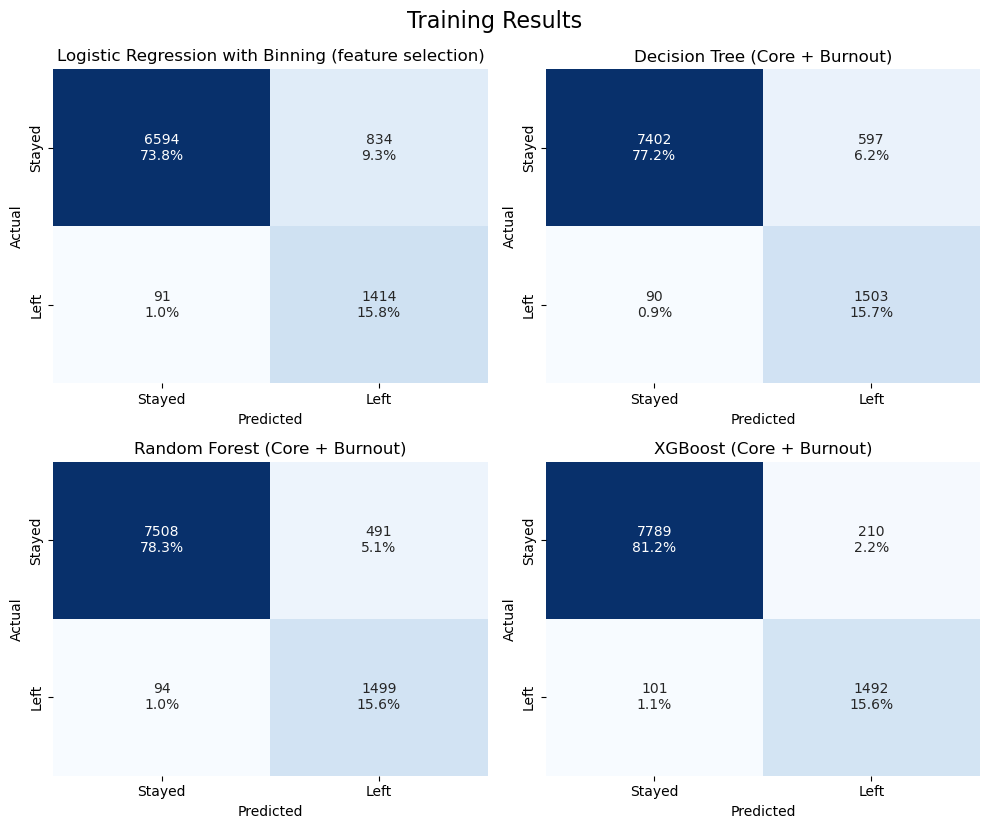

In [56]:
# plot confusion matrices for test results

# before (training/cv results)
plot_confusion_grid_from_results(results_training, png_title="Training Results")

After:

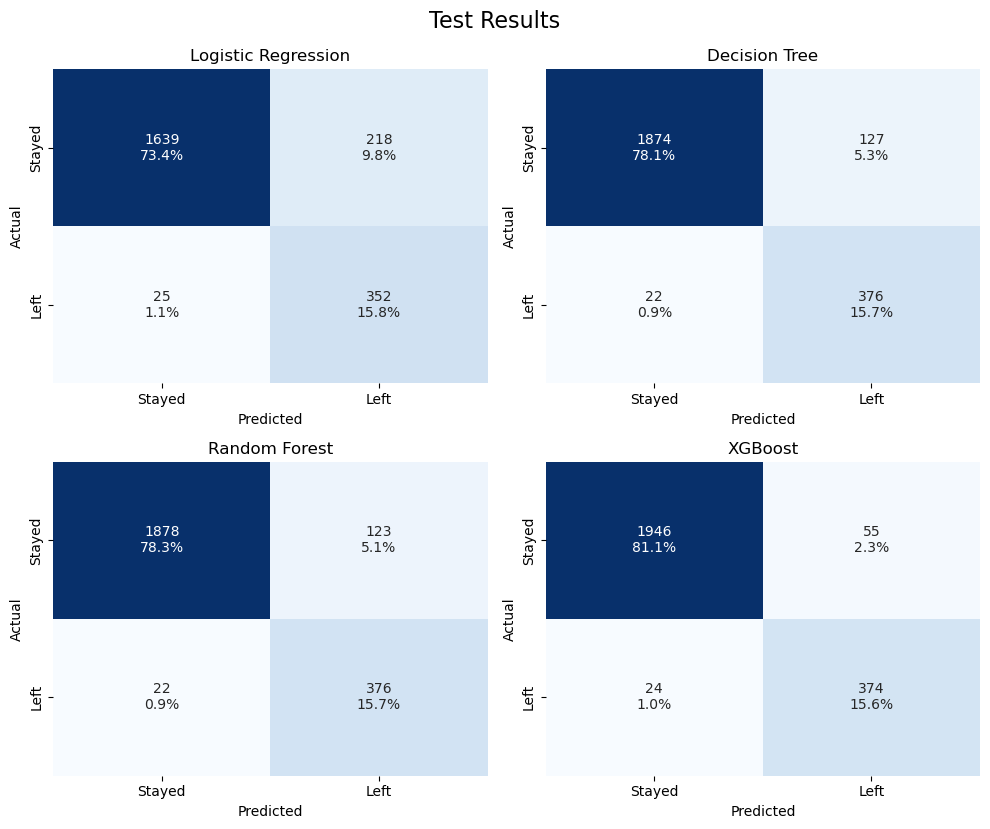

In [57]:
# after (test results)
plot_confusion_grid_from_results(results_test, png_title="Test Results")


### 📋 Model Misclassification Summary

| **Model**               | **Total Misclassified** | **False Positives (FP)** | **False Negatives (FN)** |
|---------------------|--------------------|----------------------|----------------------|
| Logistic Regression | 243                | 218                  | 25                   |
| Decision Tree       | 149                | 127                  | 22                   |
| Random Forest       | 145                | 123                  | 22                   |
| XGBoost             | 79                 | 55                   | 24                   |

**Notes**:

- **False Positives (FP)**: Predicted "Left", actually "Stayed"

- **False Negatives (FN)**: Predicted "Stayed", actually "Left"

- **Total Misclassified = FP + FN**


<div class="circle-separator-anchor"></div>

<a id="logistic-regression-interpretation"></a>

## Logistic Regression Interpretation
---

[Back to top](#)

Logistic Regression was evaluated as a baseline classifier to predict employee attrition. Despite its simplicity, it delivered strong performance in recall—correctly identifying approximately 93% of employees who left the company. This high sensitivity makes it valuable in contexts where catching potential churn is critical. 

However, the model’s performance comes with trade-offs: notably, a higher false positive rate and signs of overconfidence in its predictions. Still, its interpretability and transparency offer meaningful insights into key attrition drivers, making it a useful diagnostic tool alongside more complex models.

In [58]:
# print logistic regression metrics
display()
results_test[results_test["Model"] == "Logistic Regression"].drop(
    columns=["Best Params"]
).style.hide(axis="index")

Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Features,Confusion Matrix
Logistic Regression,0.933687,0.846968,0.743400,0.617544,0.891226,0.744055,0.948275,14,"[[1639, 218], [25, 352]]"


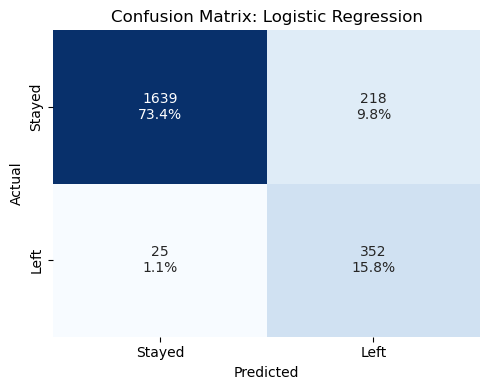

In [59]:
# plot confusion matrix for logistic regression
plot_confusion_from_results(
    results_test[results_test["Model"] == "Logistic Regression"]
)

### 🔍 Feature Importance

Moderate workloads and satisfaction are protective. Longer tenure and higher average hours increase risk. Some binned features show effects opposite to their continuous versions due to **multicollinearity**. Non-linear effects are inherent to this prediciton task, exhibited in every model tested during development.

Strongest predictors of attrition (by absolute value):

- **projects_bin_medium (-2.14)**: Medium project load greatly reduces attrition risk.

- **tenure (+1.86)**: Longer tenure increases attrition risk.

- **hours_bin_medium (-1.47)**: Medium monthly hours reduce risk.

- **projects_bin_high (-1.26), hours_bin_high (-1.26)**: High project load or hours also reduce risk.

- **average_monthly_hours (+1.25)**: Higher average hours (continuous) increase risk.

- **satisfaction_level (-1.07)**: Higher satisfaction reduces risk.

Other effects:

- **satisfaction_bin_high (+0.79)**: High satisfaction (binned) increases risk (likely due to feature overlap).

- **tenure_bin_mid (-0.65)**: Mid-level tenure reduces risk.

- **number_project (+0.65)**: More projects (continuous) increase risk.

- **last_evaluation (+0.36)**: Higher evaluation slightly increases risk.

- **promotion_last_5years (-0.13)**: Recent promotion slightly reduces risk.

- **Other binned features**: Small or negligible effects.

<small>L1 regularization (Lasso) forced the logistic regression to ignore (zero out) or down-weight features that didn’t add much predictive value, especially in the presence of multicollinearity. This helps prevent overfitting and makes the model easier to interpret.</small>

In [60]:
def get_logistic_regression_coefficients(model, feature_names, top_n=None):
    """
    Return a DataFrame of coefficients (with sign) for a fitted logistic regression model.
    Args:
        model: Fitted LogisticRegression or pipeline with 'model' step.
        feature_names: List or index of feature names.
        top_n: If set, return only the top_n features by absolute value.
    Returns:
        pd.DataFrame with columns: 'Feature', 'Coefficient'
    """
    # If model is a pipeline, get the estimator
    estimator = model.named_steps["model"] if hasattr(model, "named_steps") else model

    if not hasattr(estimator, "coef_"):
        raise ValueError("Provided model does not have coefficients.")

    coefs = estimator.coef_[0]
    features = np.array(feature_names)
    df = pd.DataFrame({"Feature": features, "Coefficient": coefs})

    df["abs_coef"] = df["Coefficient"].abs()
    df = df.sort_values("abs_coef", ascending=False).drop(columns="abs_coef")

    if top_n is not None:
        df = df.head(top_n)

    return df.reset_index(drop=True)

In [61]:
# print coefficients for the best logistic regression model
display(
    get_logistic_regression_coefficients(
        lr_model, X_test_lr_fs_binned.columns, top_n=14
    ).style.hide(axis="index")
)

Feature,Coefficient
projects_bin_medium,-2.143055
tenure,1.860573
hours_bin_medium,-1.471872
projects_bin_high,-1.260723
hours_bin_high,-1.255469
average_monthly_hours,1.247562
satisfaction_level,-1.071616
satisfaction_bin_high,0.792443
tenure_bin_mid,-0.650269
number_project,0.646384


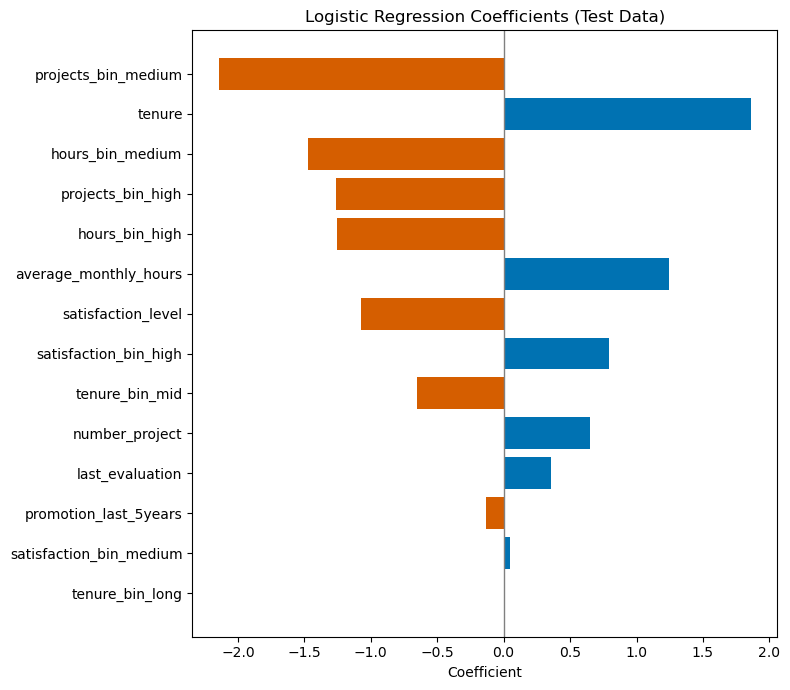

In [62]:
# plot logistic regression coefficients and precision-recall curve
lr_tuple = next((tpl for tpl in model_list if tpl[0] == "Logistic Regression"), None)
if lr_tuple:
    name, model, X_test, y_test, feature_names = lr_tuple
    # plot coefficients
    plot_logistic_regression_coefficients(
        model,
        feature_names,
        top_n=14,
        save_png=True,
        title="Logistic Regression Coefficients (Test Data)",
    )

#### 🔥SHAP summary plot

SHAP values (SHapley Additive exPlanations) provide detailed insight into how each feature influences individual predictions. Each dot represents an employee.

- **Color**: Feature value (red = high, blue = low)

- **X-axis**: Impact on prediction (negative = more likely to stay, positive = more likely to leave)


**Key Insights:**

- **High monthly hours (red)** push predictions toward "Leave"—a classic sign of burnout. Conversely, low hours (blue) are associated with "Stay."

- **High satisfaction (red)** strongly predicts "Stay," while **very low satisfaction (blue)** increases the likelihood of "Leave."

- **Longer tenure (red)** is linked to "Leave" predictions, especially for employees with 2–5 years at the company (outliers >5 years were removed for logistic regression).

- **Number of projects** shows a similar pattern: more projects shift predictions from "Stay" to "Leave."

- **Higher evaluations** have a subtle effect, slightly increasing the chance of leaving.

*Note: Ignore the binned features—multicollinearity limits interpretability for logistic regression in this context.*

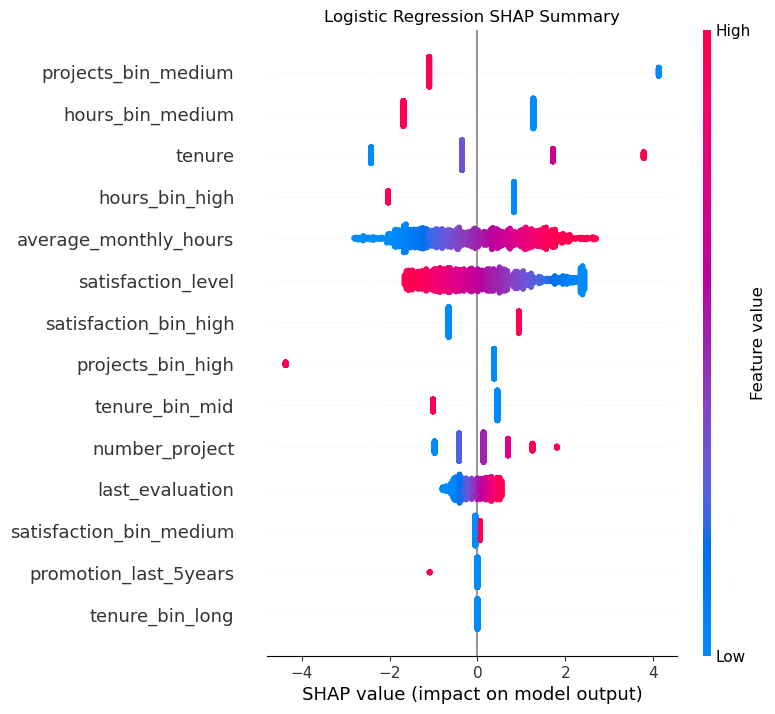

In [63]:
# plot shap summary for logistic regression
# create binned training data
X_train_lr_fs_binned = add_binning_features(X_train_lr_fs)

# fit scaler on binned training data
scaler = StandardScaler()
scaler.fit(X_train_lr_fs_binned)

# transform test data using the scaler
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_lr_fs_binned),
    columns=X_test_lr_fs_binned.columns,
    index=X_test_lr_fs_binned.index,
)

# plot shap summary for logistic regression model
plot_shap_summary(
    lr_model, X_test_scaled.astype(float), title="Logistic Regression SHAP Summary"
)

### 📉 Precision-Recall Curve
<small>Shows the trade-off between precision and recall for different classification thresholds. It is especially useful for evaluating models on imbalanced datasets, as it focuses on the performance for the positive (minority) class.</small>

The PR curve shows an immediate decline just under 0.8 precision, then levels off until about 0.8 recall, where it bends downwards fairly sharply. The model is strong at recall (few false negatives), but struggles with precision (a number of false positives).
**Average Precision (AP): 0.74**

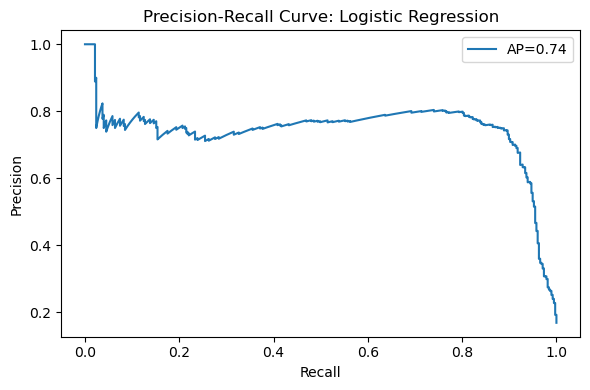

In [64]:
if lr_tuple:
    # plot precision-recall curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

### 📋 Misclassification Analysis

The **Logistic Regression** model reflects classic class imbalance behavior:

- **False Positives (Actual = 0, Predicted = 1)**: The model frequently flagged employees as likely to leave when they actually stayed, and did so with **high confidence** (avg probability ~0.76). Many had **low-to-moderate satisfaction**, **fairly high evaluations**, and **heavy workloads**, suggesting it interpreted this as burnout and made confident predictions.

- **False Negatives (Actual = 1, Predicted = 0)**: The model struggled to detect a few employees who left despite being predicted to stay. These were generally **low-risk profiles**, with **middling satisfaction**, **average workload**, and **no promotions**. Predicted probabilities were very low (avg ~0.17), indicating the model wasn’t just wrong, it was confidently wrong.

In short, Logistic Regression is **overconfident on both sides**, but especially prone to confidently overpredicting attrition for **burnout-like profiles**.

---

#### 🔴 False Positives (Predicted Left, Actually Stayed) — 218 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.457    | 0.257    | 0.120   | 1.000   |
| last_evaluation          | 0.722    | 0.172    | 0.360   | 1.000   |
| number_project           | 3.71     | 1.57     | 2       | 6       |
| average_monthly_hours    | 205.89   | 56.25    | 99      | 287     |
| tenure                   | 4.08     | 0.95     | 2       | 5       |
| promotion_last_5years    | 0.005    | 0.068    | 0       | 1       |
| predicted_proba          | 0.762    | 0.148    | 0.504   | 0.994   |

The model was **highly confident** these employees would leave, with many having probability > 0.9. But they stayed, likely due to **organizational loyalty**, resilience, or unmodeled factors like team culture or flexible hours. This misclassification points to a **burnout signal** the model leans too hard on.

---

#### 🔵 False Negatives (Predicted Stay, Actually Left) — 25 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.472    | 0.226    | 0.090   | 0.860   |
| last_evaluation          | 0.709    | 0.173    | 0.450   | 1.000   |
| number_project           | 4.08     | 1.32     | 2       | 7       |
| average_monthly_hours    | 201.84   | 42.87    | 134     | 296     |
| tenure                   | 3.08     | 0.91     | 2       | 5       |
| promotion_last_5years    | 0.000    | 0.000    | 0       | 0       |
| predicted_proba          | 0.170    | 0.156    | 0.007   | 0.488   |

These **low-confidence "stayers"** left anyway. Their profiles didn’t raise red flags for the model: average satisfaction, moderate tenure, typical workload. Their attrition may be due to **external personal factors or unobserved variables**, such as lack of growth, poor management, or life events.


In [65]:
# logistic regression's misclassified cases
lr_df_mis = pd.read_csv("../results/misclassified_cases_logistic_regression.csv")
# for label, group in lr_df_mis.groupby("actual"):
#     print(f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):")
#     print(group.describe(include="all"))

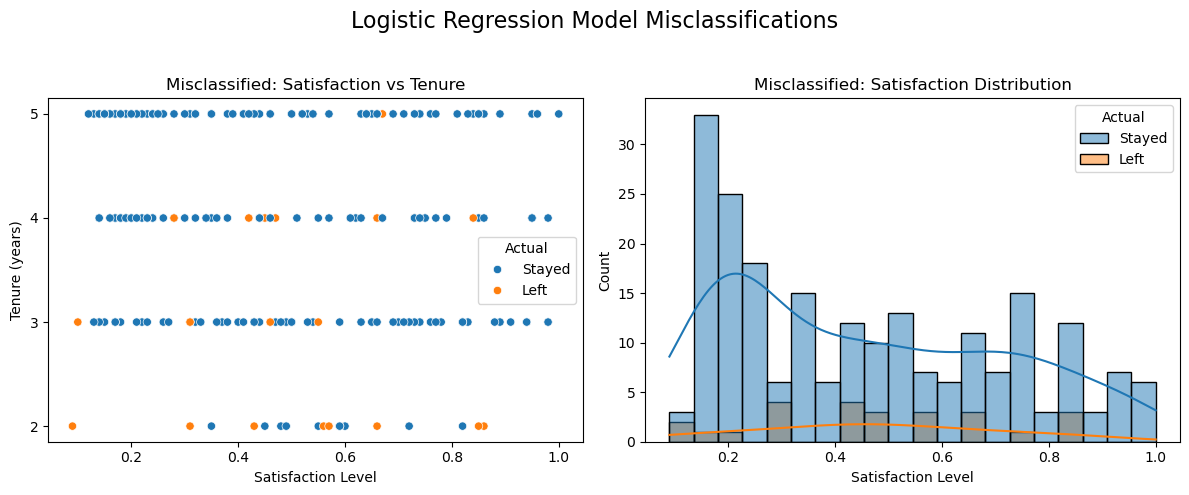

In [66]:
lr_df_mis["Actual"] = lr_df_mis["actual"].map({0: "Stayed", 1: "Left"})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Logistic Regression Model Misclassifications", fontsize=16)

# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=lr_df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Tenure")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Tenure (years)")
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# histogram: satisfaction for misclassified cases
sns.histplot(
    data=lr_df_mis,
    x="satisfaction_level",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    kde=True,
    bins=20,
    ax=axes[1],
)
axes[1].set_title("Misclassified: Satisfaction Distribution")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

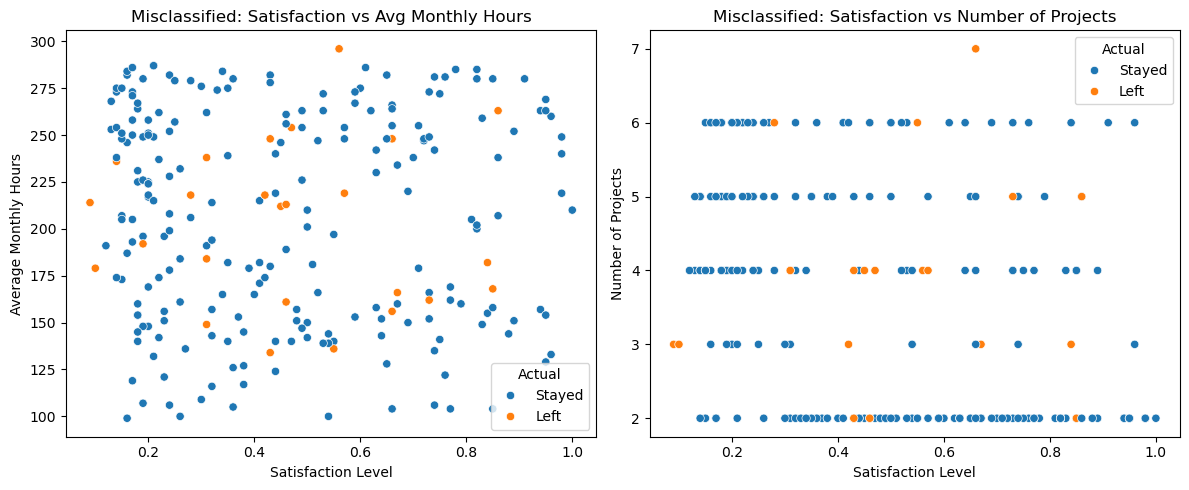

In [67]:
lr_df_mis["Actual"] = lr_df_mis["actual"].map({0: "Stayed", 1: "Left"})
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter plot: satisfaction vs average_monthly_hours
sns.scatterplot(
    data=lr_df_mis,
    x="satisfaction_level",
    y="average_monthly_hours",
    hue="Actual",
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Avg Monthly Hours")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Average Monthly Hours")

# scatter plot: satisfaction vs number_project
sns.scatterplot(
    data=lr_df_mis, x="satisfaction_level", y="number_project", hue="Actual", ax=axes[1]
)
axes[1].set_title("Misclassified: Satisfaction vs Number of Projects")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Number of Projects")
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### 📊 Predicted Probability Distribution


The **Logistic Regression** model is notably **overconfident**, especially in its false positives:

- When it **incorrectly predicted "left"** (actual = stayed), it often did so with **very high confidence** — a large cluster of predicted probabilities were **above 0.9**, and many more were spread throughout 0.5–0.9. The average proba was ~0.76, suggesting the model is **certainly misclassifying some borderline loyal employees** as churn risks.

- When it **incorrectly predicted "stayed"** (actual = left), the predicted probabilities were **consistently low**, clustered **below 0.1**, with a small uptick near the decision threshold. The average proba was ~0.17.

This distribution indicates that the model is **not well-calibrated**: it's confident in its predictions — right or wrong — and less capable of expressing uncertainty. Logistic regression’s linearity and strong class imbalance likely contribute to this **binary confidence** profile.


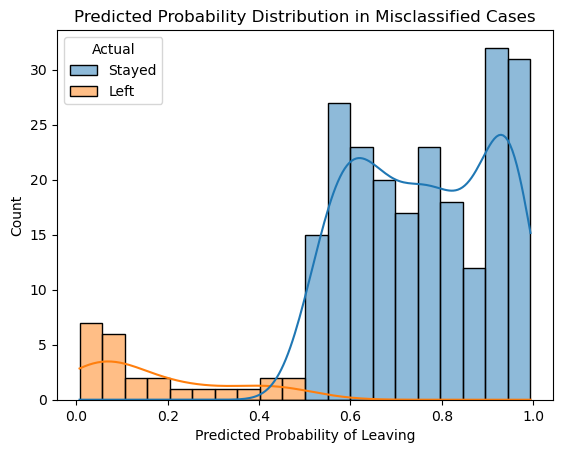

In [68]:
sns.histplot(data=lr_df_mis, x="predicted_proba", hue="Actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

### 🧠 Overall Assessment

While Logistic Regression falls short in precision compared to more advanced classifiers, its high recall and ease of interpretation justify its use as a baseline and explanatory model. It demonstrates a clear pattern: employees with medium workloads and satisfaction are at reduced risk, while **longer tenure and high average hours are strong predictors of churn**. Multicollinearity between binned and continuous features limits clean interpretability, but key patterns emerge nonetheless. Importantly, its misclassifications—especially confident false positives—highlight burnout-like profiles the model may overweigh. These findings can help shape feature engineering and interpret results from tree-based models that offer improved performance but reduced transparency.

<div class="circle-separator-anchor"></div>

<a id="decision-tree-interpretation"></a>

## Decision Tree Interpretation
---

[Back to top](#)

We evaluated a Decision Tree classifier to predict employee churn, using features related to employee engagement, performance, and demographics. The primary focus of this analysis was on **recall**, given the priority of identifying employees likely to leave. The model was relatively interpretable and performed reasonably well, though with evident trade-offs in precision and generalization.

- **Primary splits** on `satisfaction_level` and `tenure`:  
  - Low satisfaction (≤0.47) and varying tenure/hours determine leave/stay decisions.
  - Higher satisfaction (>0.47) combines with tenure and workload features.

- **Key decision nodes**: low satisfaction + mid tenure + high hours = leave; high satisfaction + moderate workload = stay.


In [69]:
# print decision tree metrics
display()
results_test[results_test["Model"] == "Decision Tree"].drop(
    columns=["Best Params"]
).style.hide(axis="index")

Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Features,Confusion Matrix
Decision Tree,0.944724,0.897375,0.834628,0.747515,0.937891,0.765587,0.956471,7,"[[1874, 127], [22, 376]]"


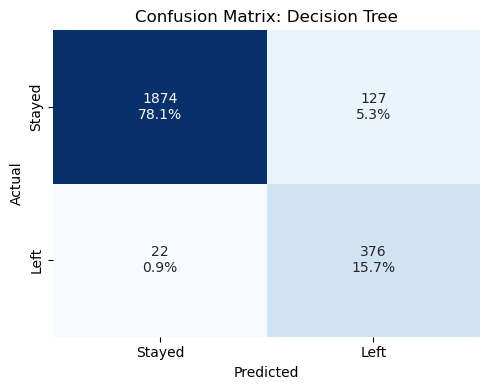

In [70]:
# plot confusion matrix for decision tree
plot_confusion_from_results(results_test[results_test["Model"] == "Decision Tree"])

### 🌳 Decision Tree Summary

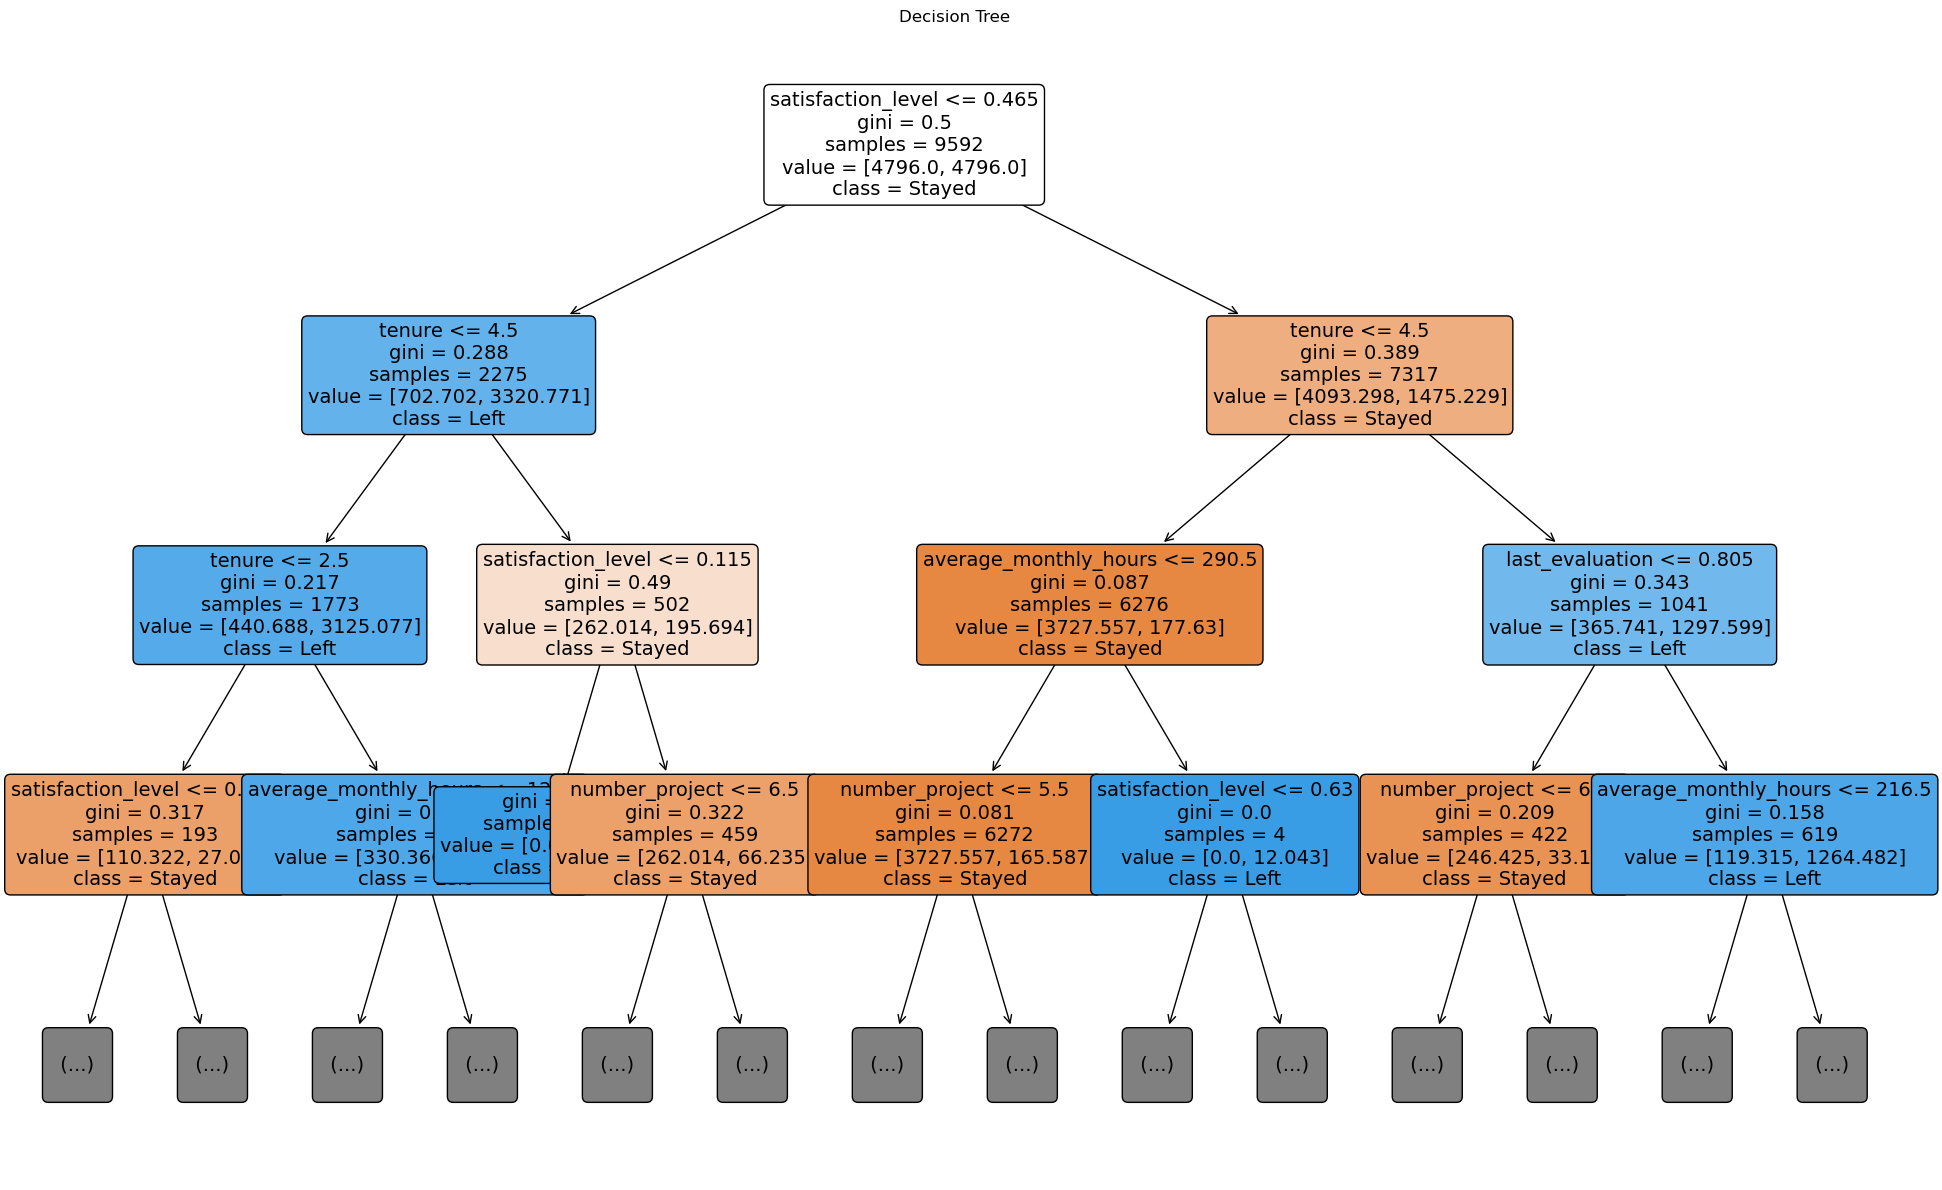

In [71]:
# load decision tree model and plot the tree

dt_model = joblib.load("../results/saved_models/best_decision_tree_model.joblib")
estimator = dt_model.named_steps["model"]

# ensure feature_names matches columns used for training
# sklearn requires a list of strings, not a pandas index or series
feature_names = list(X_test_tree.columns)

plt.figure(figsize=(20, 12))
plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=["Stayed", "Left"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=14,
)
plt.title("Decision Tree")
plt.tight_layout()

plt.savefig("../results/images/best_decision_tree_model_visualization.png")

plt.show()


### 🌟 Primary Split:
- **satisfaction_level ≤ 0.47** → More likely to **Leave**, especially with low tenure or high hours.  
- **satisfaction_level > 0.47** → More likely to **Stay**, especially if tenure is low and projects/hours are moderate.

---

### 🟥 If satisfaction_level ≤ 0.47:

#### 📌 Tenure ≤ 4.5
- **Tenure ≤ 2.5**
  - Very low satisfaction (≤ 0.15) and moderate-to-high hours → **Left**
  - Else → **Stayed**
- **Tenure > 2.5**
  - Low hours or low evaluation → **Stayed**
  - High evaluation → **Left**

#### 📌 Tenure > 4.5
- **Very low satisfaction (≤ 0.11)** → **Left**
- Else:
  - **Many projects or very high hours** → **Left**
  - **Fewer projects and moderate hours** → **Stayed**

---

### ✅ If satisfaction_level > 0.47:

#### 📌 Tenure ≤ 4.5
- **Hours ≤ 290.5**
  - **Projects ≤ 6** → **Stayed**
  - **Projects > 6** → **Left**
- **Hours > 290.5** → **Left**, regardless of satisfaction level (even if > 0.63)

#### 📌 Tenure > 4.5
- **Last eval ≤ 0.81**
  - **Projects ≤ 6** → **Stayed**
  - **Projects > 6** → **Left**
- **Last eval > 0.81**
  - **Low hours → Stayed**
  - **High hours → Left**, unless tenure is very high (> 6.5)

---

### 🔑 Key Features Driving Decisions:
- `satisfaction_level`
- `tenure`
- `average_monthly_hours`
- `number_project`
- `last_evaluation`



#### 🌳 Scrollable Outline with Splits:

In [72]:
# export decision tree rules as HTML with colors and formatting
estimator = dt_model.named_steps["model"]

tree_rules = export_text(estimator, feature_names=list(X_test_tree.columns))
tree_rules = tree_rules.replace("class: 0", "class: Stayed").replace(
    "class: 1", "class: Left"
)

feature_colors = {
    "satisfaction_level": "#1f77b4",
    "last_evaluation": "#ff7f0e",
    "number_project": "#2ca02c",
    "average_monthly_hours": "#d62728",
    "tenure": "#9467bd",
    "promotion_last_5years": "#8c564b",
    "burnout": "#e377c2",
}

# Get the value (class counts) for each node in pre-order
node_values = estimator.tree_.value.astype(int).squeeze()
if node_values.ndim == 1:
    node_values = node_values[:, None]  # ensure shape (n_nodes, n_classes)


# Helper to walk the tree in pre-order and get node indices for each line
def get_preorder_node_indices(tree):
    # Returns a list of node indices in pre-order traversal
    stack = [0]
    preorder = []
    while stack:
        node = stack.pop()
        preorder.append(node)
        # Right child pushed first so left is processed first
        if tree.children_right[node] != -1:
            stack.append(tree.children_right[node])
        if tree.children_left[node] != -1:
            stack.append(tree.children_left[node])
    return preorder


preorder_indices = get_preorder_node_indices(estimator.tree_)

html_lines = []
node_line_idx = 0  # index for preorder_indices

label_map = {0: "Stayed", 1: "Left"}  # adjust if your class labels are different

for line in tree_rules.splitlines():
    if not line.strip():
        continue  # skip empty lines
    indent = len(line) - len(line.lstrip())
    content = line.strip()
    # use regex to extract feature name
    match = re.search(r"([a-zA-Z_][a-zA-Z0-9_]*)\s*[<>=]", content)
    feature = match.group(1) if match else None
    color = feature_colors.get(feature, "#333")
    # Only increment node index for non-empty lines
    if node_line_idx < len(preorder_indices):
        node_idx = preorder_indices[node_line_idx]
        value = node_values[node_idx]
        value_str = f" | Value = [Stayed: {value[0]}, Left: {value[1]}]"
        pred_class_idx = np.argmax(value)
        pred_class_label = estimator.classes_[pred_class_idx]
        pred_class_str = label_map.get(pred_class_label, str(pred_class_label))
    else:
        value_str = ""
        pred_class_str = ""
    if "class:" in content:
        # Remove the old class: ... text and replace with actual label
        content = re.sub(r"class:.*", f"class: {pred_class_str}", content)
        html_line = (
            f'<div style="margin-left:{indent*18}px;'
            "background:#e6ffe6;"
            "border-radius:6px;"
            "padding:2px 8px;"
            "margin-bottom:2px;"
            "font-weight:bold;"
            "color:#20732d;"
            'box-shadow:0 1px 4px #b2dfdb;">'
            f'<span title="Leaf node">🍃</span> {content}{value_str}'
            "</div>"
        )
    else:
        html_line = (
            f'<div style="margin-left:{indent*18}px;'
            f"color:{color};"
            "padding:2px 8px;"
            "margin-bottom:2px;"
            "border-left:3px solid #eee;"
            'transition:background 0.2s;"'
            f" onmouseover=\"this.style.background='#f0f8ff'\" onmouseout=\"this.style.background=''\">"
            f'<span title="Split node">🌳</span> <b>{content}</b>'
            "</div>"
        )
    html_lines.append(html_line)
    node_line_idx += 1  # increment only for non-empty lines

html_tree = "\n".join(html_lines)

custom_css = """
<style>
.tree-scroll { max-height: 600px; overflow-y: auto; border: 1px solid #ddd; border-radius: 8px; background: #fafbfc; padding: 10px; }
</style>
"""

display(
    HTML(
        custom_css
        + f'<div class="tree-scroll" style="font-family:monospace;white-space:pre;line-height:1.5;">{html_tree}</div>'
    )
)

In [73]:
def get_tree_feature_importance(model, feature_names, top_n=None):
    """
    Return a DataFrame of feature importances for a fitted tree-based model.
    Args:
        model: Fitted tree model or pipeline with 'model' step.
        feature_names: List or index of feature names.
        top_n: If set, return only the top_n features by importance.
    Returns:
        pd.DataFrame with columns: 'Feature', 'Importance'
    """
    # If model is a pipeline, get the estimator
    estimator = model.named_steps["model"] if hasattr(model, "named_steps") else model

    if not hasattr(estimator, "feature_importances_"):
        raise ValueError("Provided model does not have feature_importances_.")

    importances = estimator.feature_importances_
    features = np.array(feature_names)
    df = pd.DataFrame({"Feature": features, "Importance": importances})

    df = df.sort_values("Importance", ascending=False)

    if top_n is not None:
        df = df.head(top_n)

    return df.reset_index(drop=True)

### 🔍 Feature Importance

The tree overwhelmingly relies on **tenure** and **satisfaction_level**, which jointly make up over 84% of the total feature importance. These are highly intuitive predictors for churn, where low satisfaction or mid-length tenure employees are at higher risk.

In [74]:
# print the feature importances for the decision tree model
display(
    get_tree_feature_importance(dt_model, X_test_tree.columns).style.hide(axis="index")
)

Feature,Importance
tenure,0.421398
satisfaction_level,0.420542
last_evaluation,0.092148
average_monthly_hours,0.054863
number_project,0.011049
promotion_last_5years,0.000000
burnout,0.000000


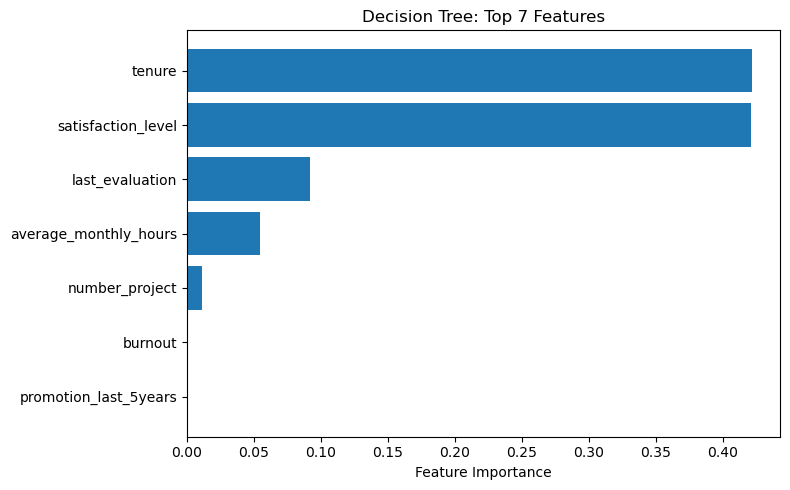

In [75]:
# plot feature importances and precision-recall curve for Decision Tree model
dt_tuple = next((tpl for tpl in model_list if tpl[0] == "Decision Tree"), None)
if dt_tuple:
    name, model, X_test, y_test, feature_names = dt_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)

### 📉 Precision-Recall Curve
<small>Shows the trade-off between precision and recall for different classification thresholds. It is especially useful for evaluating models on imbalanced datasets, as it focuses on the performance for the positive (minority) class.</small>

The PR curve shows a gentle decline in precision from 1.0 to ~0.825, gradually leveling off around 0.2 recall, falling sharply past 0.95 recall. The model is strong at recall (few false negatives), but not perfect at precision (some false positives).
**Average Precision (AP): 0.77**

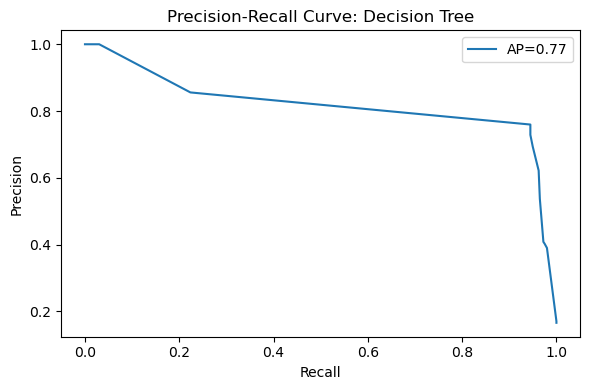

In [76]:
if dt_tuple:
    # plot precision-recall curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

### 📋 Misclassification Analysis

False predictions cluster mostly around **3–4 years of tenure** and **low satisfaction**, confirming our expectations from the feature importance rankings.

---

#### 🔴 False Positives (Predicted Left, Actually Stayed) — 127 cases

| Feature                 | Mean   | Std Dev | Min    | Max    |
|-------------------------|--------|---------|--------|--------|
| Satisfaction Level      | 0.313  | 0.171   | 0.12   | 0.90   |
| Last Evaluation         | 0.750  | 0.155   | 0.45   | 1.00   |
| Number of Projects      | 4.23   | 1.31    | 2      | 6      |
| Monthly Hours           | 213.19 | 46.76   | 126    | 287    |
| Tenure (Years)          | 3.87   | 0.86    | 3      | 6      |
| Promotion (5 Years)     | 1.57%  | 12.50%  | 0.0%   | 100.0% |
| Predicted Probability   | 0.910  | 0.086   | 0.584  | 0.975  |

False positives overwhelmingly had **low satisfaction**, **average evaluation scores**, and clustered around **3–4 years of tenure**, a tenure range linked to higher voluntary turnover but here **misjudged**.

---

#### 🔵 False Negatives (Predicted Stay, Actually Left) — 22 cases

| Feature                 | Mean   | Std Dev | Min    | Max    |
|-------------------------|--------|---------|--------|--------|
| Satisfaction Level      | 0.636  | 0.189   | 0.17   | 0.89   |
| Last Evaluation         | 0.700  | 0.143   | 0.45   | 1.00   |
| Number of Projects      | 4.18   | 1.05    | 2      | 6      |
| Monthly Hours           | 213.95 | 52.59   | 128    | 281    |
| Tenure (Years)          | 3.64   | 1.47    | 2      | 6      |
| Promotion (5 Years)     | 0.0%   | 0.0%    | 0.0%   | 0.0%   |
| Predicted Probability   | 0.095  | 0.079   | 0.024  | 0.285  |

False negatives had **moderate satisfaction**, but still within the **dissatisfaction spectrum** (relative to leavers). These are likely **borderline churn risks**, not flagged confidently enough by the tree.


In [77]:
# decision tree's misclassified cases
dt_df_mis = pd.read_csv("../results/misclassified_cases_decision_tree.csv")
# for label, group in dt_df_mis.groupby("actual"):
#     print(
#         f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):"
#     )
#     print(group.describe(include="all"))

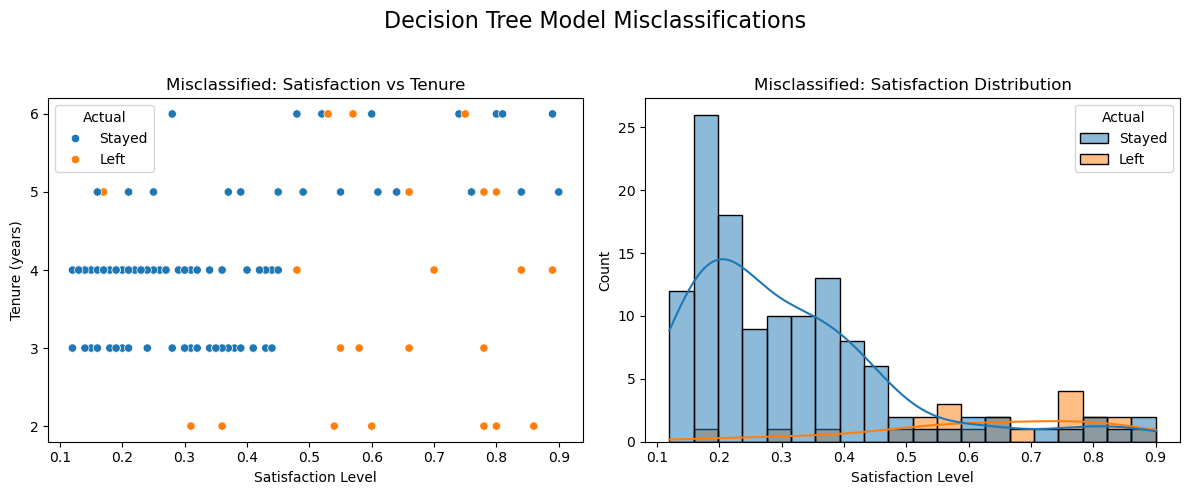

In [78]:
dt_df_mis["Actual"] = dt_df_mis["actual"].map({0: "Stayed", 1: "Left"})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Decision Tree Model Misclassifications", fontsize=16)

# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=dt_df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Tenure")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Tenure (years)")
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# histogram: satisfaction for misclassified cases
sns.histplot(
    data=dt_df_mis,
    x="satisfaction_level",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    kde=True,
    bins=20,
    ax=axes[1],
)
axes[1].set_title("Misclassified: Satisfaction Distribution")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

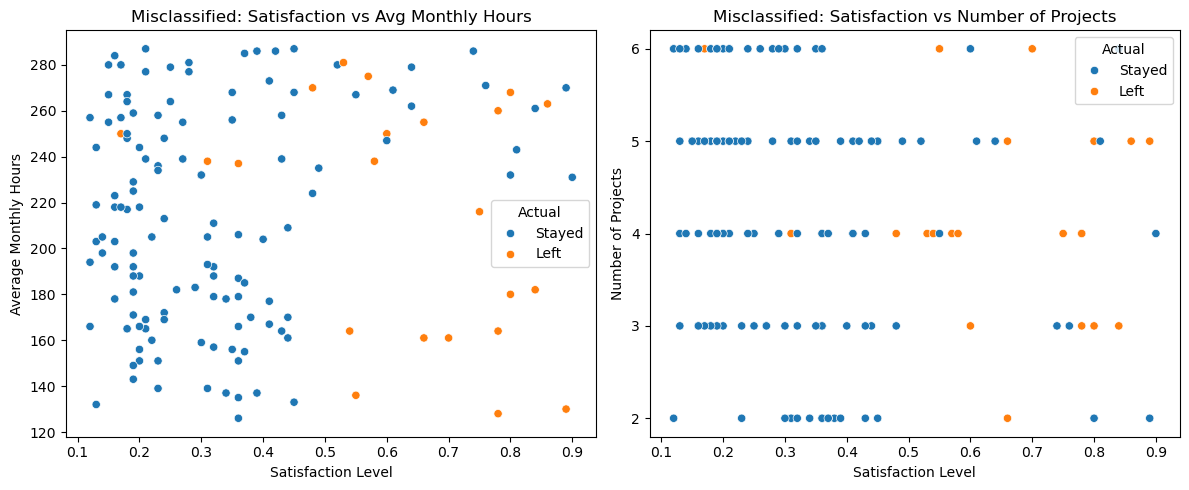

In [79]:
dt_df_mis["Actual"] = dt_df_mis["actual"].map({0: "Stayed", 1: "Left"})
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter plot: satisfaction vs average_monthly_hours
sns.scatterplot(
    data=dt_df_mis,
    x="satisfaction_level",
    y="average_monthly_hours",
    hue="Actual",
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Avg Monthly Hours")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Average Monthly Hours")

# scatter plot: satisfaction vs number_project
sns.scatterplot(
    data=dt_df_mis, x="satisfaction_level", y="number_project", hue="Actual", ax=axes[1]
)
axes[1].set_title("Misclassified: Satisfaction vs Number of Projects")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Number of Projects")
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### 📊 Predicted Probability Distribution

The predicted probabilities for **misclassified** cases reveal a strong overconfidence by the Decision Tree model:

- When the model **incorrectly predicted "left"** (actual = stayed), it was highly confident, with probabilities clustered around **0.91** (mean = 0.91, min = 0.58, max = 0.97).
- When the model **incorrectly predicted "stayed"** (actual = left), it was again quite confident, with probabilities averaging **0.095** (min = 0.02, max = 0.28).

This indicates that while the model performs well overall, its **errors are made with high confidence**, lacking probabilistic nuance. In contrast to more calibrated classifiers like Random Forest or Logistic Regression, the Decision Tree makes **binary, decisive predictions** even when wrong.


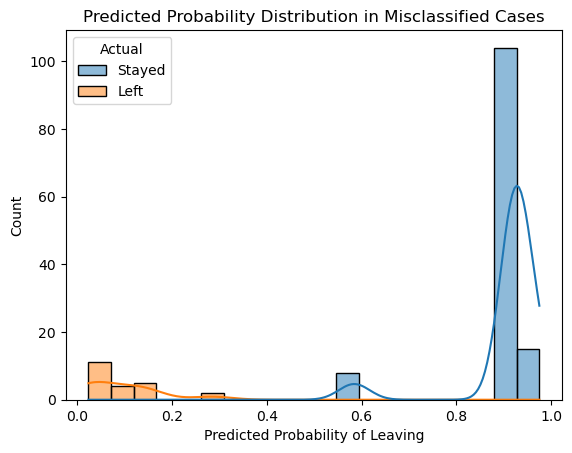

In [80]:
sns.histplot(data=dt_df_mis, x="predicted_proba", hue="Actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

### 🧠 Overall Assessment

The Decision Tree model captures key churn drivers well, especially **satisfaction level** and **tenure**, and demonstrates decent recall performance. However, it suffers from a **binary confidence pattern** and occasional overreach, especially in employees that fit the pattern of high-risk of departure, at **3–4 year tenure** with **low satisfaction**, leading to a number of false positives.

Future model improvement could include pruning or ensemble methods (e.g., Random Forest, XGBoost - see below) to smooth out prediction certainty and reduce overfitting around hard splits. For operational use, threshold tuning and targeted interventions on mid-tenure, low-satisfaction employees may prove most effective.

<div class="circle-separator-anchor"></div>

<a id="random-forest-interpretation"></a>

## Random Forest Interpretation
---

[Back to top](#)

The Random Forest model performed slightly better than the Decision Tree, maintaining a strong recall (0.945) and improving marginally in precision and F₂ score. It strikes a reliable balance between catching most leavers and minimizing false positives. However, like most ensemble models, interpretability is reduced compared to single-tree models. Feature importance is heavily skewed toward satisfaction level and tenure, which dominate model decisions.

In [81]:
# print random forest metrics
display()
results_test[results_test["Model"] == "Random Forest"].drop(
    columns=["Best Params"]
).style.hide(axis="index")

Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Features,Confusion Matrix
Random Forest,0.944724,0.899091,0.838350,0.753507,0.939558,0.946198,0.978260,7,"[[1878, 123], [22, 376]]"


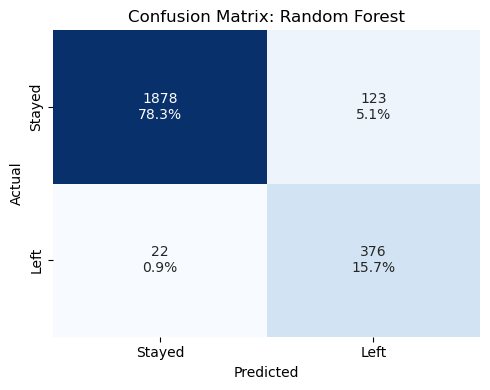

In [82]:
# plot confusion matrix for random forest
plot_confusion_from_results(results_test[results_test["Model"] == "Random Forest"])

### 🔍 Feature Importance

The tree overwhelmingly relies on **satisfaction_level** and **tenure**, which jointly make up over 83% of the total feature importance. These are highly intuitive predictors for churn, where low satisfaction or mid-length tenure employees are at higher risk.

In [83]:
# print the feature importances for the random forest model
display(
    get_tree_feature_importance(rf_model, X_test_tree.columns).style.hide(axis="index")
)

Feature,Importance
satisfaction_level,0.420294
tenure,0.411007
last_evaluation,0.095843
average_monthly_hours,0.054253
number_project,0.018581
burnout,0.000012
promotion_last_5years,0.000010


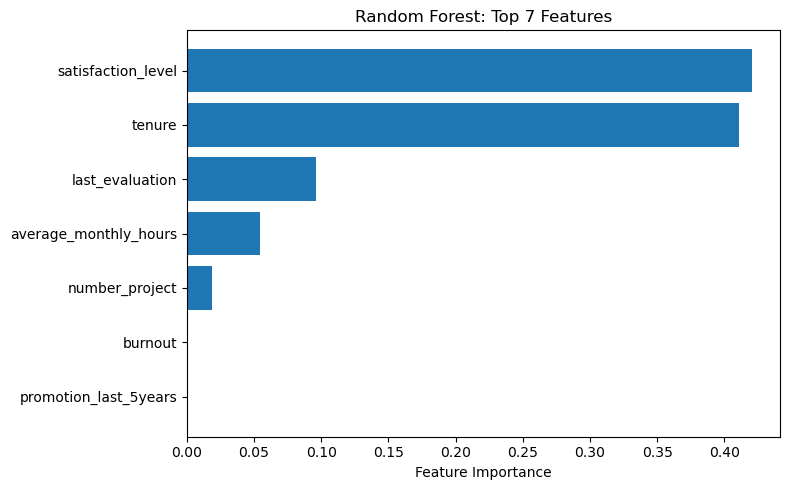

In [84]:
# plot feature importances and precision-recall curve for random forest model
rf_tuple = next((tpl for tpl in model_list if tpl[0] == "Random Forest"), None)
if rf_tuple:
    name, model, X_test, y_test, feature_names = rf_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)

### 📉 Precision-Recall Curve
<small>Shows the trade-off between precision and recall for different classification thresholds. It is especially useful for evaluating models on imbalanced datasets, as it focuses on the performance for the positive (minority) class.</small>

The PR curve is nearly linear and hovers close to 1.0, sharply declining only at very high recall values, reflecting the model’s stability in identifying true positives.  
**Average Precision (AP): 0.95**

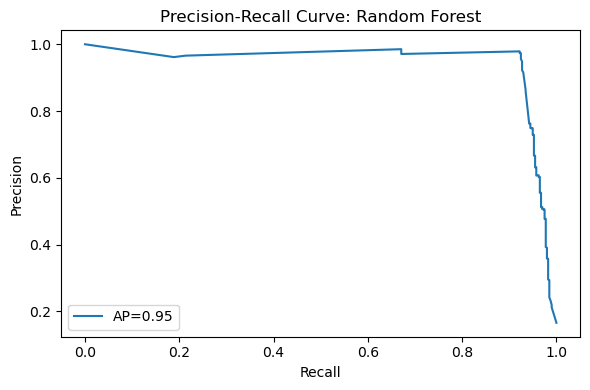

In [85]:
if rf_tuple:
    # plot precision-recall curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

### 📋 Misclassification Analysis

The Random Forest model showed similar patterns to XGBoost in terms of error type and confidence levels:

- **False Positives (Actual = 0, Predicted = 1)**: Most had **low satisfaction** but **high evaluation**, with a **high predicted probability** (avg ~0.82). The model was very confident they would leave.
- **False Negatives (Actual = 1, Predicted = 0)**: These were employees with **moderate-to-high satisfaction**, but predicted to stay with **low confidence** (avg proba ~0.13), again suggesting **strong class separation**.

It's exhibiting model behavior typical of **class imbalance with high separability for only one class** (burned-out leavers). It’s doing a decent job overall, but it keeps misclassifying those **edge-case stayers** (burned-out but loyal) and **quiet quitters** (who look fine but leave).

---

#### 🔴 False Positives (Predicted Left, Actually Stayed) — 123 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.316    | 0.173    | 0.120   | 0.900   |
| last_evaluation          | 0.751    | 0.152    | 0.450   | 1.000   |
| number_project           | 4.20     | 1.32     | 2       | 6       |
| average_monthly_hours    | 210.98   | 45.83    | 126     | 287     |
| tenure                   | 3.82     | 0.83     | 3       | 6       |
| promotion_last_5years    | 0.02     | 0.13     | 0       | 1       |
| predicted_proba          | 0.8220   | 0.0634   | 0.5046  | 0.9772  |

Most false positives had **very high model confidence**, with probabilities consistently >0.5. Indicates overconfidence in identifying at-risk employees with medium dissatisfaction.
- Strong confidence these people were going to leave (but they didn’t).
- These false positives are driven by low satisfaction_level (mean = 0.316).
- Many had high last_evaluation, high monthly_hours, and a decent number of projects (median = 5).
- Burnout signal again.

---

#### 🔵 False Negatives (Predicted Stay, Actually Left) — 22 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.636    | 0.189    | 0.170   | 0.890   |
| last_evaluation          | 0.700    | 0.143    | 0.450   | 1.000   |
| number_project           | 4.18     | 1.05     | 2       | 6       |
| average_monthly_hours    | 213.95   | 52.59    | 128     | 281     |
| tenure                   | 3.64     | 1.47     | 2       | 6       |
| promotion_last_5years    | 0.00     | 0.00     | 0       | 0       |
| predicted_proba          | 0.1262   | 0.1228   | 0.0265  | 0.4287  |

False negatives were **low-confidence predictions**, indicating the model generally "believed" they would stay, but without high certainty. Indicates model confusion when people seem reasonably content but still exit, perhaps due to personal reasons not captured in data.
- Low confidence they were going to stay (and they didn't stay).
- These are false negatives.
- These employees had decent satisfaction (mean = 0.636), decent evaluations, average monthly hours (~214), and again, no promotions, low tenure (median = 3.5), and almost all not flagged as burned out.
- These are probably low-risk leavers the model doesn't know how to spot well.


In [86]:
# random forest's misclassified cases
rf_df_mis = pd.read_csv("../results/misclassified_cases_random_forest.csv")
# for label, group in rf_df_mis.groupby("actual"):
#     print(
#         f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):"
#     )
#     print(group.describe(include="all"))

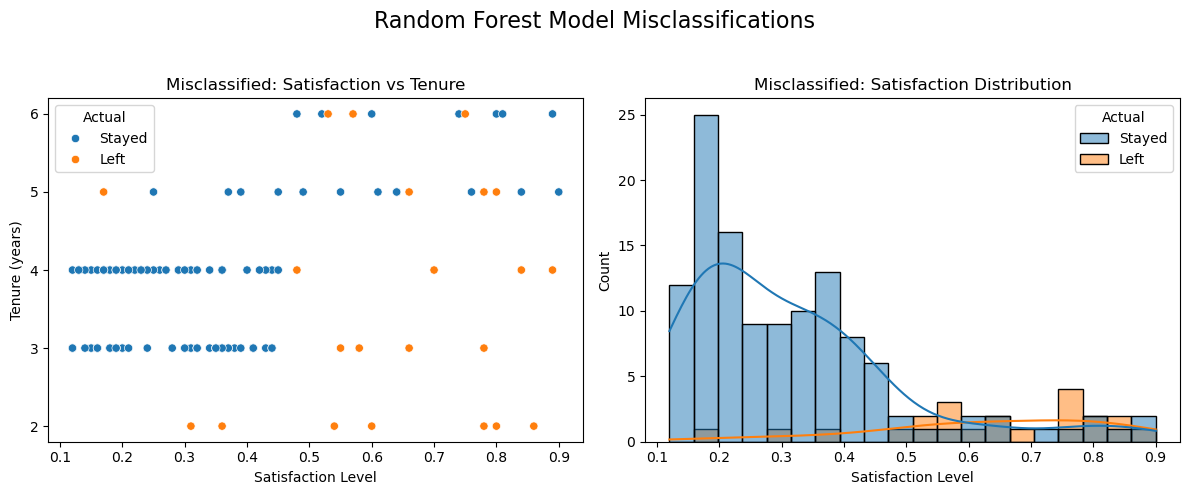

In [87]:
rf_df_mis["Actual"] = rf_df_mis["actual"].map({0: "Stayed", 1: "Left"})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Random Forest Model Misclassifications", fontsize=16)

# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=rf_df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Tenure")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Tenure (years)")
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# histogram: satisfaction for misclassified cases
sns.histplot(
    data=rf_df_mis,
    x="satisfaction_level",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    kde=True,
    bins=20,
    ax=axes[1],
)
axes[1].set_title("Misclassified: Satisfaction Distribution")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

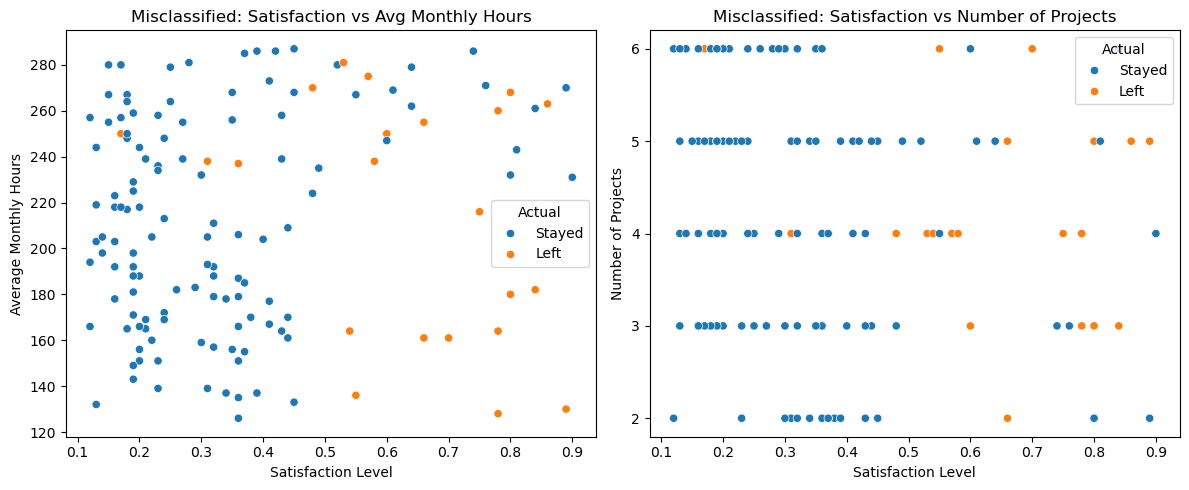

In [88]:
rf_df_mis["Actual"] = rf_df_mis["actual"].map({0: "Stayed", 1: "Left"})
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter plot: satisfaction vs average_monthly_hours
sns.scatterplot(
    data=rf_df_mis,
    x="satisfaction_level",
    y="average_monthly_hours",
    hue="Actual",
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Avg Monthly Hours")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Average Monthly Hours")

# scatter plot: satisfaction vs number_project
sns.scatterplot(
    data=rf_df_mis, x="satisfaction_level", y="number_project", hue="Actual", ax=axes[1]
)
axes[1].set_title("Misclassified: Satisfaction vs Number of Projects")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Number of Projects")
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### 📊 Predicted Probability Distribution

The predicted probabilities for **misclassified** cases show that the Random Forest model, while better calibrated than the Decision Tree, still makes confident errors:

- When the model **incorrectly predicted "left"** (actual = stayed), it was fairly confident, with probabilities clustered around **0.82** (min = 0.50, max = 0.98).

- When the model **incorrectly predicted "stayed"** (actual = left), it showed low predicted probabilities, averaging **0.13** (min = 0.03, max = 0.43).

This suggests the model is **more probabilistically nuanced** than the Decision Tree, but it still tends to **overcommit** on burned-out-looking employees leaving, and struggles to catch a few lower-risk leavers.

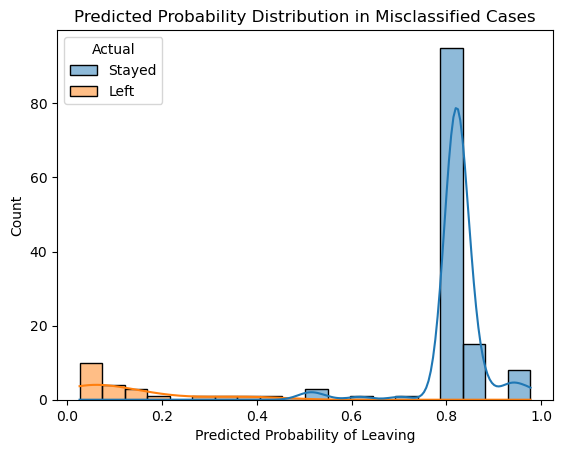

In [89]:
sns.histplot(data=rf_df_mis, x="predicted_proba", hue="Actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

### 🧠 Overall Assessment

The Random Forest model balances recall and precision well, with improved calibration over a single tree. The model, like most classifiers in this context, struggles with "gray area" employees who fall between clear satisfaction and dissatisfaction thresholds. This is expected in real-world HR analytics, where exits often happen for unmeasurable or personal reasons (e.g., career growth, relocation, family needs, interpersonal conflict, or random opportunity). This intrinsic uncertainty places a ceiling on prediction accuracy, especially when limited features are available.

<div class="circle-separator-anchor"></div>

<a id="xgboost-interpretation"></a>

## XGBoost Interpretation
---

[Back to top](#)

XGBoost performed exceptionally well across all evaluation metrics, demonstrating high precision and recall, as well as excellent overall accuracy.


In [90]:
# print XGBoost metrics
display(
    results_test[results_test["Model"] == "XGBoost"]
    .drop(columns=["Best Params"])
    .style.hide(axis="index")
)

Model,Recall,F2 Score,F1 Score,Precision,Accuracy,PR AUC,ROC AUC,Features,Confusion Matrix
XGBoost,0.939698,0.925285,0.904474,0.871795,0.967070,0.966941,0.982202,7,"[[1946, 55], [24, 374]]"


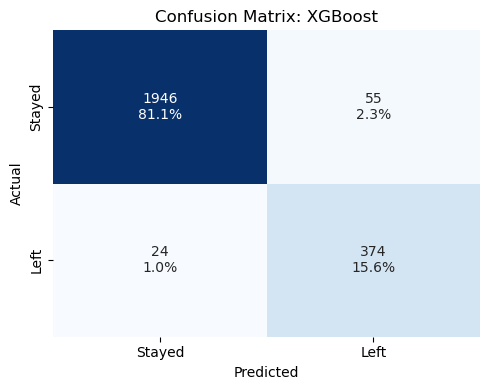

In [91]:
# plot confusion matrix for xgboost
plot_confusion_from_results(results_test[results_test["Model"] == "XGBoost"])

### 🔍 Feature Importance

The tree overwhelmingly relies on **satisfaction_level** and **tenure**, which jointly make up over 83% of the total feature importance. These are highly intuitive predictors for churn, where low satisfaction or mid-length tenure employees are at higher risk.

In [92]:
# print the feature importances for the random forest model
display(
    get_tree_feature_importance(rf_model, X_test_tree.columns).style.hide(axis="index")
)

Feature,Importance
satisfaction_level,0.420294
tenure,0.411007
last_evaluation,0.095843
average_monthly_hours,0.054253
number_project,0.018581
burnout,0.000012
promotion_last_5years,0.000010


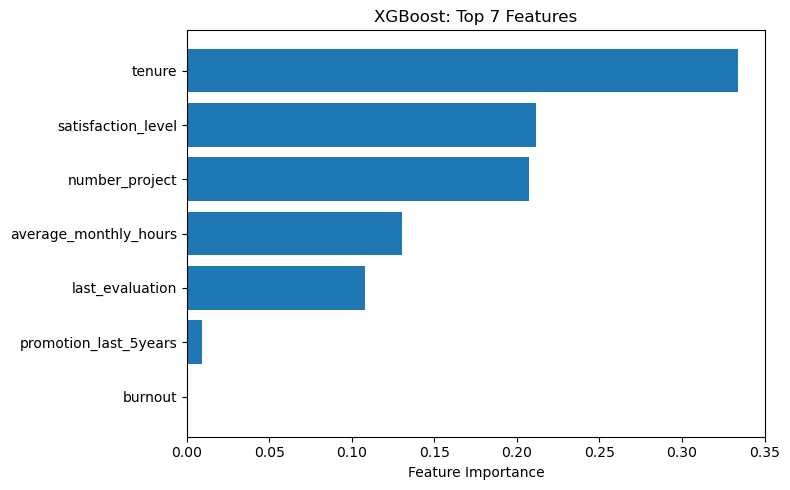

In [93]:
# plot feature importances and precision-recall curve for XGBoost model
xgb_tuple = next((tpl for tpl in model_list if tpl[0] == "XGBoost"), None)
if xgb_tuple:
    name, model, X_test, y_test, feature_names = xgb_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)

#### 🔥SHAP summary plot

SHAP values (SHapley Additive exPlanations) provide detailed insight into how each feature influences individual predictions. Each dot represents an employee.

- **Color**: Feature value (red = high, blue = low)

- **X-axis**: Impact on prediction (negative = more likely to stay, positive = more likely to leave)

**Key Insights:**

- **High satisfaction (red)** strongly predicts “Stay.”  

- **Very low satisfaction (blue)** increases the likelihood of “Leave.”

- **High tenure (red)** is linked to “Leave” predictions, but very high tenure swings back toward “Stay” (as seen in EDA). Low tenure generally predicts “Stay.”

- **Low project count (blue)** (disengaged) and **very high project count (red)** (burnout) both increase risk of leaving.

- **Very high hours (red)** are associated with leaving; low hours (blue) with staying. The middle range is mixed, with a slight lean toward staying.

- **High evaluations (red)** slightly push toward leaving, while many lower-evaluated employees (blue) stay, suggesting some high performers are at risk.

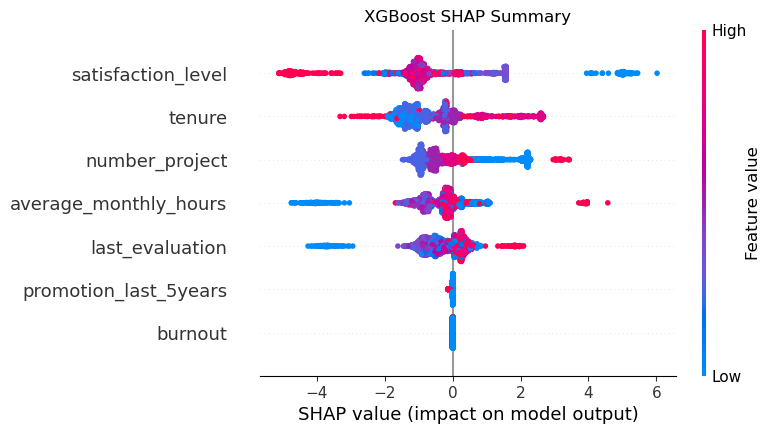

In [94]:
# plot shap summary for XGBoost model
plot_shap_summary(xgb_model, X_test_tree, title="XGBoost SHAP Summary")

### 📉 Precision-Recall Curve
<small>Shows the trade-off between precision and recall for different classification thresholds. It is especially useful for evaluating models on imbalanced datasets, as it focuses on the performance for the positive (minority) class.</small>

The PR curve is nearly linear and hovers close to 1.0, sharply declining only at very high recall values, reflecting the model’s stability in identifying true positives.  
**Average Precision (AP): 0.97**

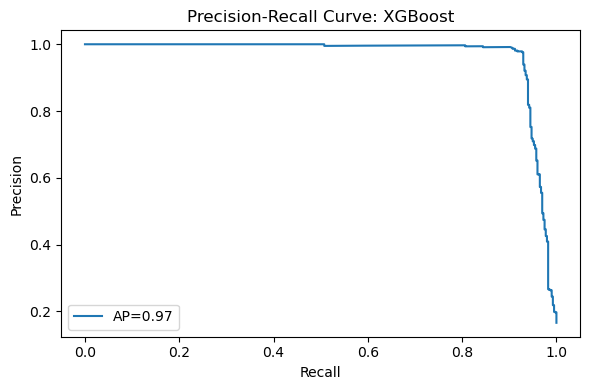

In [95]:
if xgb_tuple:
    # plot precision-recall curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

### 📋 Misclassification Analysis

Misclassified examples are broadly distributed across different levels of **tenure** and **satisfaction**. Some false positives (predicted leave, actually stayed) cluster around satisfaction levels of **0.35** and **0.85**, but counts remain in single digits.

---

#### 🔴 False Positives (Predicted Left, Actually Stayed) — 55 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.581    | 0.217    | 0.130   | 0.900   |
| last_evaluation          | 0.749    | 0.185    | 0.450   | 1.000   |
| number_project           | 3.84     | 1.50     | 2       | 6       |
| average_monthly_hours    | 210.27   | 56.94    | 126     | 286     |
| tenure                   | 4.58     | 0.98     | 2       | 6       |
| promotion_last_5years    | 0.02     | 0.13     | 0       | 1       |
| predicted_proba          | 0.7425   | 0.1403   | 0.5016  | 0.9826  |

Most false positives had moderately high confidence.

---

#### 🔵 False Negatives (Predicted Stay, Actually Left) — 24 cases

| Feature                  | Mean     | Std Dev  | Min     | Max     |
|--------------------------|----------|----------|---------|---------|
| satisfaction_level       | 0.555    | 0.229    | 0.170   | 0.890   |
| last_evaluation          | 0.663    | 0.134    | 0.450   | 0.990   |
| number_project           | 4.17     | 1.05     | 2       | 6       |
| average_monthly_hours    | 212.67   | 47.61    | 128     | 281     |
| tenure                   | 3.58     | 1.28     | 2       | 6       |
| promotion_last_5years    | 0.00     | 0.00     | 0       | 0       |
| predicted_proba          | 0.1190   | 0.1022   | 0.0088  | 0.3481  |

False negatives generally had low predicted probabilities, suggesting the model was confident they would stay.


In [96]:
# xgboost's misclassified cases
xgb_df_mis = pd.read_csv("../results/misclassified_cases_xgboost.csv")
# for label, group in xgb_df_mis.groupby("actual"):
#     print(
#         f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):"
#     )
#     print(group.describe(include="all"))

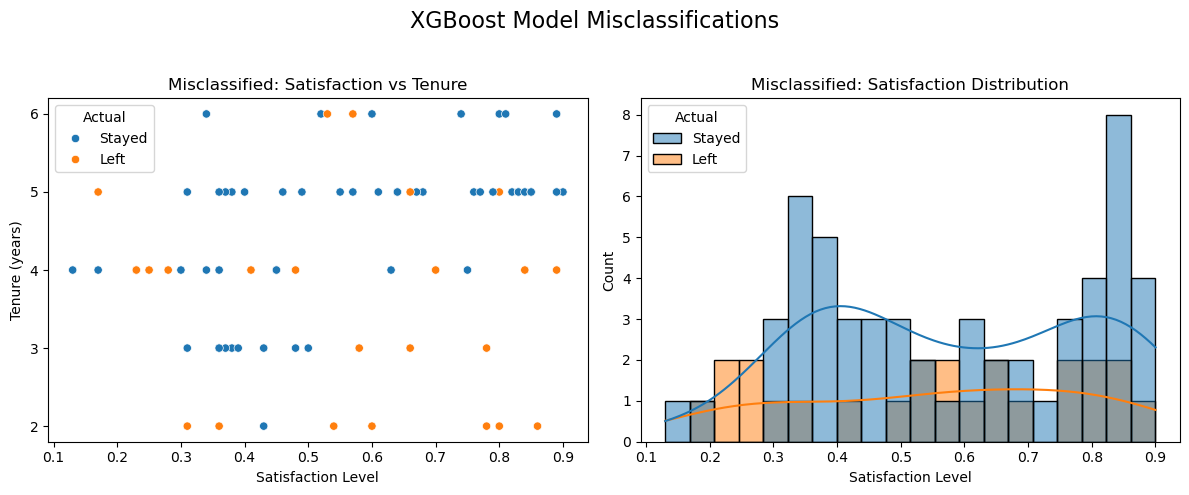

In [97]:
xgb_df_mis["Actual"] = xgb_df_mis["actual"].map({0: "Stayed", 1: "Left"})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("XGBoost Model Misclassifications", fontsize=16)

# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=xgb_df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Tenure")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Tenure (years)")
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# histogram: satisfaction for misclassified cases
sns.histplot(
    data=xgb_df_mis,
    x="satisfaction_level",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    kde=True,
    bins=20,
    ax=axes[1],
)
axes[1].set_title("Misclassified: Satisfaction Distribution")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

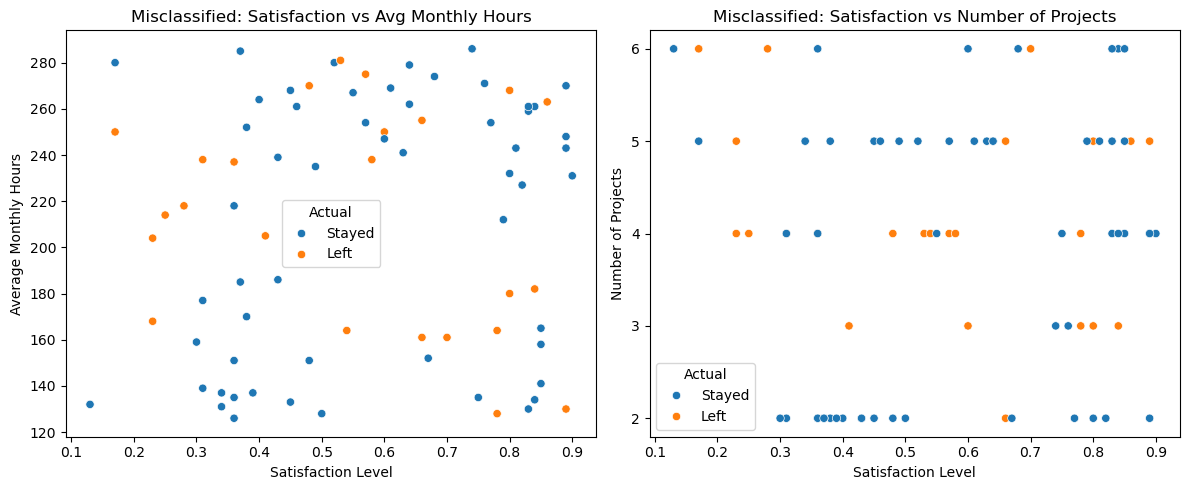

In [98]:
xgb_df_mis["Actual"] = xgb_df_mis["actual"].map({0: "Stayed", 1: "Left"})
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter plot: satisfaction vs average_monthly_hours
sns.scatterplot(
    data=xgb_df_mis,
    x="satisfaction_level",
    y="average_monthly_hours",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[0],
)
axes[0].set_title("Misclassified: Satisfaction vs Avg Monthly Hours")
axes[0].set_xlabel("Satisfaction Level")
axes[0].set_ylabel("Average Monthly Hours")

# scatter plot: satisfaction vs number_project
sns.scatterplot(
    data=xgb_df_mis,
    x="satisfaction_level",
    y="number_project",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    ax=axes[1],
)
axes[1].set_title("Misclassified: Satisfaction vs Number of Projects")
axes[1].set_xlabel("Satisfaction Level")
axes[1].set_ylabel("Number of Projects")
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### 📊 Predicted Probability Distribution

The XGBoost model shows **more spread and nuance** in its misclassified predictions than the Decision Tree or Random Forest, but still leans toward overconfidence:

- When it **incorrectly predicted "left"** (actual = stayed), predicted probabilities were high but **more varied**, with a mean of 0.74 and a range from **0.50** to **0.98**.

- When it **incorrectly predicted "stayed"** (actual = left), it tended to be underconfident, with probabilities centered around **0.12** (min = 0.01, max = 0.35).

This distribution suggests that XGBoost, while not perfectly calibrated, **preserves more probabilistic uncertainty**, especially compared to the binary overconfidence of the Decision Tree. It's more cautious — but still misses on both sides.

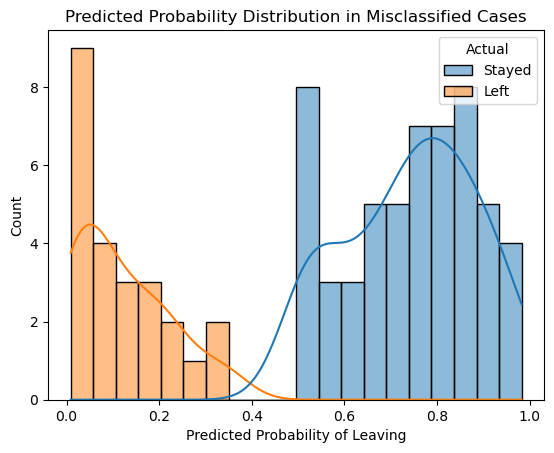

In [99]:
sns.histplot(
    data=xgb_df_mis,
    x="predicted_proba",
    hue="Actual",
    hue_order=["Stayed", "Left"],
    bins=20,
    kde=True,
)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

### 🧠 Overall Assessment

XGBoost outperformed all other models on nearly every metric. It balances strong discrimination and improved calibration over simpler models. Its high **recall**, **precision**, and **AUC** make it a strong candidate for deployment, particularly when correctly identifying leavers is critical. The tree overwhelmingly relies on **tenure** and **satisfaction level** to make predictions. Misclassification patterns reinforce the idea that the model struggles most with borderline cases, employees with mid-to-low satisfaction around years 3–4. These are often ambiguous profiles: employees possibly dissatisfied but not clearly on the way out.

Overall, XGBoost provides the strongest predictive performance of all models tested. However, its complexity and opacity may present interpretability challenges in an HR context, especially for stakeholders who require transparent decision logic.

<div class="circle-separator-anchor"></div>

<a id="cross-model-reflection"></a>

## Cross‑Model Reflection
---

[Back to top](#)

- XGBoost shows the strongest predictive performance.
- All models consistently show turnover related to extreme workloads and around 4 years of tenure.
- All models show difficulty with **borderline “gray‑area” employees** (mid tenure with moderate dissatisfaction), highlighting challenges inherent in HR predictive modeling.
- This reflects real-world turnover motivations (e.g., opportunities, life changes) not captured by features, an expected limitation of the model.
- To improve edge‑case predictions: consider incorporating more behavioral or temporal features, employing probability calibration, or using mixed-methods (e.g., qualitative feedback) alongside these models.


<div class="circle-separator-anchor"></div>

<a id="conclusion"></a>

# **Conclusion**
---

[Back to top](#)

*This section presents a concluding summary of model strengths with key insights for business decision-making.*

### Narrative Summary & Business Insights

The predictive models developed for employee attrition at Salifort Motors consistently identified **key risk factors** such as low satisfaction, high workload, and mid-level tenure. They also revealed a persistent challenge: all models struggled to accurately predict outcomes for “gray-area” employees, particularly those with moderate dissatisfaction and 3-4 years of tenure. This limitation reflects the complex, multifaceted nature of turnover, where personal motivations and external factors often go unmeasured.

### Key Business Insights:

- **Burnout and Disengagement**: Employees with low satisfaction or extreme workloads (high and low) are at highest risk. Monitoring these factors, especially for those at the 3-4 year mar, should be a priority.

- **Borderline Cases**: Many misclassifications occurred among employees who did not fit clear risk profiles, highlighting the need for richer data (e.g., behavioral signals, qualitative feedback) and more nuanced modeling.

- **Retention Levers**: Opportunities for advancement, recognition, and work-life balance emerged as actionable levers to reduce attrition risk.

- **Model as Early Warning**: The model is best used as an early warning system to flag at-risk employees for supportive HR outreach, not as a punitive tool.

### Recommendations:

1. **Monitor Satisfaction & Workload**: Regularly survey employees and track workload to identify those at risk of burnout or disengagement.

1. **Targeted Retention Efforts**: Focus on employees with low satisfaction and extreme workloads, especially those at 3-4 years of tenure.

1. **Promotions & Recognition**: Increase opportunities for advancement and recognition to boost engagement.

1. **Work-Life Balance**: Encourage reasonable project loads and monthly hours to reduce burnout.

1. **Stay Interviews**: Engage employees approaching critical tenure milestones to understand and address their concerns.

1. **Transparent Communication**: Clearly explain how predictive models are used, emphasizing support and fairness.

### Next Steps:

- **Model Deployment**: Integrate the model into HR processes for early identification of at-risk employees.

- **Continuous Improvement**: Retrain and calibrate the model as new data becomes available; expand data sources to include engagement surveys and qualitative feedback.

- **Bias & Fairness Audits**: Routinely check for bias and monitor for unintended consequences.

- **Ethical Safeguards**: Ensure employee data privacy, fairness, and transparency in all predictive analytics initiatives.

### Ethical Considerations:

Maintain strict data privacy. Use predictions to support, not penalize, employees. Communicate transparently about the model’s purpose and limitations. Regular audits for bias and fairness are essential to uphold trust and integrity.

---

In summary, while predictive modeling offers valuable guidance for HR strategy, its greatest value lies in augmenting, not replacing, human judgment and supportive engagement. Combining model insights with ongoing feedback and ethical safeguards will help Salifort Motors proactively retain talent and foster a healthier workplace.



<h3 class="button-section-title">Continue Exploring:</h3>

<div class="button-row">
  <div class="button">
    <a href="../index.html">Executive Summary</a>
  </div>
  <div class="button">
    <a href="eda.html">Exploratory Data Analysis</a>
  </div>
</div>

<div class="circle-separator-anchor"></div>

<a id="appendix-data-dictionary"></a>

# Appendix: Data Dictionary
---

[Back to top](#)

### Original Dataset

After removing duplicates, the dataset contained 11,991 rows and 10 columns for the variables listed below. 

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Feature Engineering Data Dictionary


The following table describes the engineered features created for model development. These features are derived from the original dataset using binning, interaction terms, and logical flags to capture important patterns identified during exploratory data analysis.

Variable  |Description |
-----|-----|
**Bins** | |
satisfaction_bin_low | Binary indicator: satisfaction_level is low (≤ 0.4) |
satisfaction_bin_medium | Binary indicator: satisfaction_level is medium (> 0.4 and ≤ 0.7) |
satisfaction_bin_high | Binary indicator: satisfaction_level is high (> 0.7) |
hours_bin_low | Binary indicator: average_monthly_hours is low (≤ 160) |
hours_bin_medium | Binary indicator: average_monthly_hours is medium (> 160 and ≤ 240) |
hours_bin_high | Binary indicator: average_monthly_hours is high (> 240) |
projects_bin_low | Binary indicator: number_project is low (≤ 2) |
projects_bin_medium | Binary indicator: number_project is medium (> 2 and ≤ 5) |
projects_bin_high | Binary indicator: number_project is high (> 5) |
tenure_bin_short | Binary indicator: tenure is short (≤ 3 years) |
tenure_bin_mid | Binary indicator: tenure is mid (> 3 and ≤ 5 years) |
tenure_bin_long | Binary indicator: tenure is long (> 5 years) |
**Interactions** | |
satisfaction_x_projects | Interaction: satisfaction_level × number_project |
satisfaction_x_hours | Interaction: satisfaction_level × average_monthly_hours |
evaluation_x_satisfaction | Interaction: last_evaluation × satisfaction_level |
hours_per_project | Ratio: average_monthly_hours divided by number_project |
**Flags** | |
burnout | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3 |
disengaged | Flag: True if (number_project ≤ 2 and average_monthly_hours < 160 and satisfaction_level ≤ 0.5) |
no_promo_4yr | Flag: True if promotion_last_5years == 0 and tenure ≥ 4 |

**Note:**  
Binned features are one-hot encoded as separate columns (e.g., satisfaction_bin_low, satisfaction_bin_medium, satisfaction_bin_high). Only the relevant dummy variables (excluding the first category for each bin) are included in the final dataset, depending on the encoding strategy.

<div class="circle-separator-anchor"></div>

<a href id="appendix-feature-engineering"></a>

# Appendix: Feature Engineering
---

[Back to Top](#)

In addition to baseline models run with all original features, all feature engineering varieties below were tested with all four model types: **Logistic Regression**, **Decision Tree**, **Random Forest**, and **XGBoost**.

### Feature Engineering Round One

**Original features + binning**:
This set adds binned versions of key variables (satisfaction, workload, projects, tenure) to the original features. Binning helps capture non-linear effects and threshold-based risk groups identified in EDA (e.g., low/medium/high satisfaction, extreme workloads, tenure windows).

**Original features + interactions**:
This set augments the original features with interaction terms that capture relationships between satisfaction, workload, and performance (e.g., satisfaction × projects, satisfaction × hours, evaluation × satisfaction, hours per project). These interactions help distinguish between disengaged, overworked, and healthy employees.

**Original features + categorical flags**:
This set adds logical flag features to the original data, such as "burnout" (overworked and dissatisfied), "disengaged" (underworked and dissatisfied), and "no_promo_4yr" (long tenure without promotion). These flags directly encode high-risk employee profiles identified in EDA.

**Feature selection**:
For each of the above, a feature selection variant was also run, dropping weak predictors (department, salary, work_accident) to reduce noise and multicollinearity, especially for logistic regression.

### Feature Engineering Round Two

**Selected features + burnout flag:**
This set isolates the core predictors of attrition (satisfaction, workload, tenure, promotion) and adds a “burnout” flag to capture the high-risk group of overworked, dissatisfied employees

**Selected features + interactions:**
This set focuses on the main drivers (satisfaction, workload, tenure) and adds interaction terms (satisfaction × projects, hours per project) to capture non-linear effects and workload intensity, which EDA showed are important for distinguishing between underworked, overworked, and healthy employees.

**Selected features + interactions + burnout flag:**
This feature set combines the core predictors of attrition (satisfaction, workload, tenure) with a “burnout” flag to capture high-risk, overworked employees. It also includes a key interaction term, "satisfaction × projects", to distinguish between groups identified in EDA

<div class="circle-separator-anchor"></div>

<a href id="appendix-hyperparameters"></a>

# Appendix: Hyperparameter Tuning Grids
---

[Back to Top](#)

This section summarizes the hyperparameter grids used for model selection and tuning via `GridSearchCV` and `RandomizedSearchCV` for all baseline and feature-engineered models.

---

### **Logistic Regression**

**Baseline Grid:**
```python
lr_base_param_grid = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength (inverse)
        "model__penalty": ["l1", "l2"],             # L1 (Lasso) or L2 (Ridge)
        "model__solver": ["liblinear"],             # Supports L1/L2
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    }
}
```

**Feature Engineering Grid:**
```python
lr_fe_params = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"],
}
```

---

### **Decision Tree**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "Decision Tree": {
        "model__max_depth": [4, 6, 8, None],        # Max tree depth
        "model__min_samples_leaf": [1, 2, 5],       # Min samples at leaf
        "model__min_samples_split": [2, 4, 6],      # Min samples to split
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "Decision Tree": {
        "model__max_depth": [3, 4, 5, 6, 8],
        "model__min_samples_leaf": [1, 2, 3],
        "model__min_samples_split": [2, 3, 4],
        "model__class_weight": [None, "balanced"],
    },
    ...
}
```

---

### **Random Forest**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "Random Forest": {
        "model__n_estimators": [300, 500],          # Number of trees
        "model__max_depth": [3, 5, None],           # Max tree depth
        "model__max_features": ["sqrt", 1.0],       # Features considered at each split
        "model__max_samples": [0.7, 1.0],           # Fraction of samples per tree
        "model__min_samples_leaf": [1, 2, 3],       # Min samples at leaf
        "model__min_samples_split": [2, 3, 4],      # Min samples to split
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "Random Forest": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 4, 5, 8],
        "model__max_features": ["sqrt", 1.0],
        "model__max_samples": [0.7, 1.0],
        "model__min_samples_leaf": [1, 2],
        "model__min_samples_split": [2, 3],
        "model__class_weight": [None, "balanced"],
    },
    ...
}
```

---

### **XGBoost**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "XGBoost": {
        "model__n_estimators": [100, 300],              # Number of boosting rounds
        "model__max_depth": [3, 5, 7],                  # Max tree depth
        "model__learning_rate": [0.01, 0.1, 0.2],       # Step size shrinkage
        "model__subsample": [0.6, 0.8, 1.0],            # Row subsampling
        "model__colsample_bytree": [0.6, 0.8, 1.0],     # Feature subsampling
        "model__min_child_weight": [1, 5, 10],          # Min sum of instance weight in a child
        "model__gamma": [0, 0.1, 0.2],                  # Min loss reduction to split
        "model__scale_pos_weight": [1, scale_pos_weight_value],  # Class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "XGBoost": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 4, 5, 8],
        "model__learning_rate": [0.1, 0.2],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0],
        "model__min_child_weight": [1, 5],
        "model__gamma": [0, 0.1, 0.2],
        "model__scale_pos_weight": [1, scale_pos_weight_value],
        "model__reg_alpha": [0, 0.1, 1],            # L1 regularization
        "model__reg_lambda": [1, 2, 5],             # L2 regularization
    },
    ...
}
```

---

**Notes:**
- All hyperparameters were tuned using either `GridSearchCV` (for smaller grids or faster models) or `RandomizedSearchCV` (for larger grids or slower models).
- `scale_pos_weight_value` is dynamically calculated as the ratio of negative to positive samples in the training set to address class imbalance for XGBoost.
- For all models, `model__class_weight="balanced"` was included as an option to help mitigate class imbalance.
- Feature engineering grids used slightly smaller or more regularized search spaces for efficiency.


<div class="circle-separator-anchor"></div>

<!-- Footer -->
<footer class="site-footer" role="contentinfo">
  <span class="footer-owner">
    &copy; <span id="copyright-year">2025</span>
    <span class="footer-author">Bryan C. Johns</span>
  </span>
  <span class="footer-links">
    <a href="https://johbry17.github.io/portfolio/index.html" target="_blank" class="portfolio-link" aria-label="Portfolio">
      <i class="fas fa-laptop-code footer-icon" aria-hidden="true" title="Portfolio"></i>Portfolio
    </a>
    <a href="https://www.linkedin.com/in/b-johns/" target="_blank" class="linkedin-link" aria-label="LinkedIn">
      <i class="fab fa-linkedin footer-icon" aria-hidden="true" title="LinkedIn"></i>LinkedIn
    </a>
    <a href="https://github.com/johbry17" target="_blank" class="github-link" aria-label="GitHub">
      <i class="fab fa-github footer-icon" aria-hidden="true" title="GitHub"></i>GitHub
    </a>
  </span>
</footer>
<script>
  // Auto-update year
  const yearElement = document.getElementById("copyright-year");
  if (yearElement) {
    yearElement.textContent = new Date().getFullYear();
  }
</script>

<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>
<script src="../static/js/scripts.js"></script>
<script>
  document.addEventListener('DOMContentLoaded', function() {
    insertCircleSeparator('.circle-separator-anchor');
  });
</script>

